# Animal Disease Outbreaks

I've chosen to explore and analze data on [animal disease outbreaks](https://www.kaggle.com/tentotheminus9/empres-global-animal-disease-surveillance) found on Kaggle gathered by EMPRES Global Animal Disease Information System (EMPRES-i), an application created to assist veterinary services by providing information on global diseases. The ability to understand the inception and spread of these diseases and ultimately predict where and how future incidents will unfold is crucial in our efforts to combat the damage caused. While some may believe the animals' health is irrelevant to us, this couldn't be farther from the truth - on an obvious level, because roughly 90% of the world's population eats meat it is advantageous for us to keep our fellow creatures healthy. What is less known but even more important is that many epidemiologists believe it's likely that the next pandemic will come from an animal, similar to SARS, MERS, and more recently the Coronavirus that have killed thousands.


# The Data

The data includes just over 30,000 cases of animal outbreaks from 2015 to the present. Each row represents a different outbreak reported so there are some repeating diseases. Variables include timing, place, species, and diseases, as well as information on the number of animals and humans affected. I'll use clustering and other unsupervised learning techniques in an effort to learn about the onset and dispersion of animal disease outbreaks. Ideally, the data will collect in such a way that I am able to differentiate, locate, and predict outbreaks with pandemic potential. Interested parties include the CDC, WHO, and any health and government organizations responsible for responding to outbreaks.

In [32]:
import os
os.chdir('/Users/sophiaperides/Desktop/Thinkful')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import re


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import scipy.stats as stats
from scipy.stats.mstats import winsorize


import keras
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import datasets, metrics
from sklearn.neural_network import BernoulliRBM
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage as lnkg

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings(action="ignore")

In [33]:
# Combining six datasets to cover the past six years
outbreaks1 = pd.read_csv('Outbreak1.csv')
outbreaks2 = pd.read_csv('Outbreak2.csv')
outbreaks3 = pd.read_csv('Outbreak3.csv')
outbreaks4 = pd.read_csv('Outbreak4.csv')
outbreaks5 = pd.read_csv('Outbreak5.csv')
outbreaks6 = pd.read_csv('Outbreak6.csv')
outbreaks = pd.DataFrame(outbreaks1.append([outbreaks2, outbreaks3, outbreaks4, outbreaks5, outbreaks6]))
print(outbreaks.columns)
print(outbreaks.info())
outbreaks.head(10)

Index(['Id', 'source', 'latitude', 'longitude', 'region', 'country', 'admin1',
       'localityName', 'localityQuality', 'observationDate', 'reportingDate',
       'status', 'disease', 'serotypes', 'speciesDescription', 'sumAtRisk',
       'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
       'humansGenderDesc', 'humansAge', 'humansAffected', 'humansDeaths'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 4999
Data columns (total 24 columns):
Id                    30000 non-null int64
source                30000 non-null object
latitude              30000 non-null float64
longitude             30000 non-null float64
region                30000 non-null object
country               30000 non-null object
admin1                30000 non-null object
localityName          30000 non-null object
localityQuality       30000 non-null object
observationDate       29314 non-null object
reportingDate         30000 non-null object
status     

,Id,source,latitude,longitude,region,country,admin1,localityName,localityQuality,observationDate,reportingDate,status,disease,serotypes,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansGenderDesc,humansAge,humansAffected,humansDeaths
0,264093,OIE,18.240550,-70.282265,Americas,Dominican Republic,Peravia,Peravia,Exact,17/09/2019,19/12/2019,Confirmed,Newcastle disease,NaN,"domestic, chicken",13191.0,13191.0,6809.0,6382.0,NaN,NaN,NaN,NaN,NaN
1,264044,OIE,44.109900,26.804200,Europe,Romania,Calarasi,Chislet,Exact,23/12/2019,23/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,264043,OIE,44.931200,25.626100,Europe,Romania,Dimbovita,Adanca,Exact,23/12/2019,23/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,264042,OIE,45.161400,25.392900,Europe,Romania,Dimbovita,Runcu,Exact,20/12/2019,23/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",NaN,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,264041,OIE,44.974100,25.464800,Europe,Romania,Dimbovita,Viforata,Exact,19/12/2019,23/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",18.0,18.0,1.0,17.0,NaN,NaN,NaN,NaN,NaN
5,264040,OIE,45.194500,26.975600,Europe,Romania,Buzau,Boboc,Exact,12/12/2019,23/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",7.0,7.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
6,264039,OIE,47.190800,22.512200,Europe,Romania,Bihor,Lapis,Exact,20/12/2019,23/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,264038,OIE,47.743900,23.311200,Europe,Romania,Maramures,Sabisa,Exact,14/12/2019,20/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,264037,OIE,44.818976,25.821518,Europe,Romania,Dimbovita,Finta,Exact,18/12/2019,20/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
9,264036,OIE,44.666521,23.574296,Europe,Romania,Gorj,Turburea,Exact,16/12/2019,20/12/2019,Confirmed,African swine fever,NaN,"wild, wild boar",NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


# The Cleaning

More than half of the variables are not missing any data which is a great start. Empty cells in sumAtRisk, sumCases, sumDeaths, sumDestroyed, sumSlaughtered, and humansAge will be filled with the mean value of these columns. I will drop the column humansGenderDesc as there is simply not enough information for me to populate the missing values. As for humansAffected and humansDeaths, I'll populate missing values with the mode.

All dates in the data will be converted to datetime objects and create variables for the year, month, and day of the observation. Missing variables in observationDate will be filled by finding the average difference between the observationDate and reportingDate, and subtracting this number from the reportingDate. A new variable, 'differenceInDays', will be created by finding the difference between the observationDate and reportingDate for each instance. It is interesting to note that there are just over 3,700 entries with observationDate values after reportingDates. At first I assumed this is impossible, but then realized this could be the case if two datapoints we part of the same outbreak.

Dummies will be created for source, region, country, localityQuality, disease, serotypes, and status. I will delete the humansGenderDesc column as there is not enough information to impute, as well as the localityName column as I don't believe this variable offers enough information to fill the nearly fourteen thousand of cells missing values.

Just under 7,000 rows are missing information on serotypes so I will fill these with 'Unknown Serotypes'. Similarly, under 2,000 rows are missing in speciesDescription, so these will be filled with 'Unknown Species'. Additionally, the information populating these cells are lists of animals so I will create new dummy variables with keywords, including 'wild' and 'domestic'. Finally, I'll create new features 'birds' and 'mammals' which will indicate whether a disease affected these classes.




### Handling Numeric Variables

In [34]:
# Filling missing numeric variables and removing humansGenderDesc
outbreaks.serotypes.fillna('UnknownSerotypes', inplace=True)
outbreaks.speciesDescription.fillna('UnknownSpecies', inplace=True)
outbreaks.sumAtRisk.fillna(outbreaks.sumAtRisk.mean(), inplace=True)
outbreaks.sumCases.fillna(outbreaks.sumCases.mean(), inplace=True)
outbreaks.sumDeaths.fillna(outbreaks.sumDeaths.mean(), inplace=True)
outbreaks.sumDestroyed.fillna(outbreaks.sumDestroyed.mean(), inplace=True)
outbreaks.sumSlaughtered.fillna(outbreaks.sumSlaughtered.mean(), inplace=True)
outbreaks.drop(columns=['humansGenderDesc'], inplace=True)
outbreaks.humansAge.fillna(outbreaks.humansAge.mean(), inplace=True)
outbreaks.humansAffected.fillna(outbreaks.humansAffected.mode()[0], inplace=True)
outbreaks.humansDeaths.fillna(outbreaks.humansDeaths.mode()[0], inplace=True)
outbreaks.shape

(30000, 23)

### Handling Date Variables

In [35]:
# Creating a new dataframe to handle the dates
outbreaks['observationDate'] = pd.to_datetime(outbreaks['observationDate'])
outbreaks['reportingDate'] = pd.to_datetime(outbreaks['reportingDate'])
outbreaks_time = outbreaks[['observationDate', 'reportingDate']]
outbreaks_time.dropna(inplace=True)

# Find the average difference between observation and reporting dates
outbreaks_time['differenceInDays'] = (outbreaks_time['reportingDate'] - outbreaks_time['observationDate'])/np.timedelta64(1,'D')
                                                                     
print('Average difference between observation and reporting dates: ', outbreaks_time['differenceInDays'].mean())
outbreaks.observationDate.fillna(outbreaks.reportingDate - timedelta(days=33), inplace=True)

# Creating a new variable
outbreaks['differenceInDays'] = (outbreaks['reportingDate'] - outbreaks['observationDate'])/np.timedelta64(1,'D')


Average difference between observation and reporting dates:  29.083953059971346


In [36]:
# Creating variables for year, month, day, and time of month
outbreaks['observationYear'] = pd.DatetimeIndex(outbreaks['observationDate']).year
outbreaks['observationMonth'] = pd.DatetimeIndex(outbreaks['observationDate']).month
outbreaks['observationDay'] = pd.DatetimeIndex(outbreaks['observationDate']).day
outbreaks['observationFirstHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x <= 15 else 0 )
outbreaks['observationSecondHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x > 15 else 0 )

### Handling Dummy Variables

In [37]:
# Creating dummy variables and dropping localityName
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['source'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['region'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['country'])], axis=1)
outbreaks.drop(columns=['admin1', 'localityName'], inplace=True)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['localityQuality'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['status'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['disease'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['serotypes'])], axis=1)
outbreaks.shape

(30000, 279)

### Handling speciesDescription Variable

In [38]:
outbreaks.speciesDescription.unique()

array(['domestic, chicken', 'wild, wild boar', 'domestic, swine',
       'domestic, cattle', 'domestic, dog', 'domestic, cat',
       'domestic, unspecified bird', 'domestic, ostrich',
       'domestic, goat/sheep ', 'domestic, sheep',
       'wild,mute swan (cygnus olor))', 'UnknownSpecies',
       'domestic, duck', 'domestic, turkey', 'domestic, goose',
       'wild, crow', 'environmental sample, unspecified bird',
       'domestic, equidae', 'domestic, muscovy ducks', 'domestic, quail',
       'environmental sample, unspecified env. sample, environmental sample, unspecified env. sample',
       'environmental sample, unspecified env. sample', 'domestic, horse',
       'wild, unspecified bird', 'wild, owl',
       'environmental sample, unspecified bird, environmental sample, unspecified bird',
       'domestic, goat, domestic, sheep',
       'wild,rose pelican (pelecanus onocrotalus))',
       'wild,greater flamingo (phoenicopterus roseus))', 'domestic, goat',
       'domestic, catt

In [39]:
# Creating new dummy variables for species characteristics
outbreaks['wild'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'wild' in x else 0)
outbreaks['undomestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'undomestic' in x else 0)
outbreaks['domestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'domestic' in x else 0)
outbreaks['captive'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'captive' in x else 0)
outbreaks['unspecified'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'unspecified' in x else 0)
outbreaks.head(10)

,Id,source,latitude,longitude,region,country,localityQuality,observationDate,reportingDate,status,disease,serotypes,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAge,humansAffected,humansDeaths,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth,EC,FAO ECTAD RAF,FAO Field Officer,FAO officer,FAO-Report,International reference laboratory,Media,"National Institute for Communicable Diseases, NICD",National authorities,OIE,Other,UN Field Officer,WHO,sequence only,Africa,Americas,Asia,Europe,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Belize,Bhutan,Bosnia and Herzegovina,Botswana,Brazil,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Croatia,Cyprus,Czech Republic,Côte d'Ivoire,Dem People's Rep of Korea,Democratic Republic of the Congo,Denmark,Dominican Republic,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Finland,France,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Guinea,Guinea-Bissau,Honduras,"Hong Kong, SAR",Hungary,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Lesotho,Libya,Lithuania,Luxembourg,Macau,Malawi,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mayotte,Mexico,"Moldova, Republic of",Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Netherlands,Niger,Nigeria,Oman,Pakistan,Panama,Peru,Philippines,Poland,Portugal,Qatar,Republic of Korea,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Sierra Leone,Slovakia,Slovenia,South Africa,South Sudan,Spain,Sudan,Svalbard and Jan Mayen Islands,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Taiwan (Province of China),Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Tunisia,Turkey,U.K. of Great Britain and Northern Ireland,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe,Centroid Admin1,Centroid Admin2,Centroid Locality,Exact,Unknown,Confirmed,Denied,African horse sickness,African swine fever,Anthrax,Bluetongue,Bovine spongiform encephalopathy,Bovine tuberculosis,Brucellosis (Brucella abortus),Brucellosis (Brucella melitensis),Brucellosis (Brucella suis),Classical swine fever,Contagious bovine pleuropneumonia,Equine infectious anaemia,Foot and mouth disease,Glanders,Influenza - Avian,Influenza - Equine,Lumpy skin disease,MERS-CoV,Newcastle disease,Peste des petits ruminants,Porcine reproductive and respiratory syndrome,Rabies,Rift Valley fever,Sheep pox and goat pox,West Nile Fever,1,16,19,2,22,3,4,5,7,8,"8, 4",A,"A, O",APMV-I,Asia 1,H3 LPAI,H3N1 LPAI,H3N8,H5 HPAI,H5 LPAI,H5N1 HPAI,H5N1 LPAI,"H5N1 LPAI, H5N2 LPAI",H5N2 HPAI,H5N2 LPAI,"H5N2 LPAI, H6N2 LPAI","H5N2 LPAI, H7N7 LPAI",H5N3 HPAI,H5N3 LPAI,"H5N3 LPAI, H5N2 LPAI",H5N5 HPAI,H5N5 LPAI,H5N6 HPAI,H5N6 LPAI,H5N8 HPAI,"H5N8 HPAI, H5N2 HPAI",H5N8 LPAI,H5N9 HPAI,H5N9 LPAI,H6N2 LPAI,H7 LPAI,H7N1 HPAI,H7N1 LPAI,H7N2 LPAI,H7N3 HPAI,H7N3 LPAI,H7N4 LPAI,H7N6 LPAI,H7N7 HPAI,H7N7 LPAI,H7N9 HPAI,H7N9 LPAI,H9N2 LPAI,HPAI,LPAI,Not Specified,Not specified,O,SAT1,SAT2,SAT3,UnknownSerotypes,wild,undomestic,domestic,captive,unspecified
0,264093,OIE,18.240550,-70.282265,Americas,Dominican Republic,Exact,2019-09-17,2019-12-19,Confirmed,Newcastle disease,UnknownSerotypes,"domestic, chicken",13191.000000,13191.0,6809.000000,6382.000000,202.743361,8.823313,1.0,1.0,93.0,2019,9,17,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [40]:
# Creating dummy variables for animal classes
birds = ['bird', 'swan', 'turkey', 'mallard', 'goose', 'duck', 'pigeon', 'heron', 'accipitridae', 'gull', 
         'phasianidae', 'eagle', 'chicken', 'buzzard', 'falcon', 'anatidae', 'fowl', 'eider', 'pelican', 'wigeon',
        'dove', 'rook', 'stork', 'egret', ' peafowl', 'cormorant', 'coot', 'crow', 'scaup', 'teal', 'magpie', 
         'kestrel', 'blackbird', 'gadwall', 'pochard', 'shelduck', 'parrot', 'tern', ' grebe', 'flamingo', 'eagle-owl',
        'accipiter gentilis', 'ibis', 'ibex', 'emu', 'xpeacock', 'magpie-robin', 'ostrich']
mammals = ['swine', 'boar', 'equidae', 'dog', 'sheep', 'cat', 'goat/sheep', 'goat', 'camelidae', 'horse',
          'fox', 'jackal', ' saiga', 'yaks', 'hippopotamus', 'buffaloe', 'deer', 'canine', 'elephant', 'mammal', 'cattle']

outbreaks['speciesDescription'] = outbreaks.speciesDescription.apply(lambda x: re.split('\s', x))
outbreaks['birds'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(birds)) > 0  else 0) 
outbreaks['mammals'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(mammals)) > 0  else 0)

print(outbreaks.birds.value_counts())



0    23634
1     6366
Name: birds, dtype: int64


# Combining Cases

Up until now, I considered each datapoint to be an individual case. This is incorrect - more often than not, there were multiple rows containing information on the same outbreak indicating that the outbreak was reported multiple times. To handle this, I will group by country, disease, and date within seven days of the most recent case. Ideally, I would've liked to iterate through the same countries and diseases to search for all dates within seven days, but was not able to. While this is a flawed approach and a potential shortcoming, I could not find a better way to combine datapoints.

In [41]:
sum_variables = ('sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAffected', 
                 'humansDeaths')
mean_variables = ('humansAge', 'differenceInDays', 'observationYear', 'observationMonth', 'observationDay')
categorical_variables = ('observationFirstHalfMonth','observationSecondHalfMonth','EC', 'FAO ECTAD RAF', 
                    'FAO Field Officer','FAO officer','FAO-Report', 'International reference laboratory', 'Media', 
                  'National Institute for Communicable Diseases, NICD', 'National authorities', 'OIE', 'Other', 
                  'UN Field Officer','WHO', 'sequence only', 'Africa', 'Americas', 'Asia', 'Europe', 'Afghanistan',
                  'Albania','Algeria','Angola','Argentina','Armenia','Austria','Bahrain','Bangladesh','Belarus',
                  'Belgium','Belize','Bhutan','Bosnia and Herzegovina','Botswana','Brazil','Bulgaria','Burkina Faso',
                  'Burundi','Cambodia','Cameroon','Canada','Central African Republic','Chad','Chile','China','Colombia',
                  'Comoros','Croatia','Cyprus','Czech Republic','Côte d\'Ivoire','Dem People\'s Rep of Korea',
                  'Democratic Republic of the Congo','Denmark','Dominican Republic','Ecuador','Egypt','El Salvador',
                  'Estonia','Ethiopia','Finland','France','Gambia','Gaza Strip','Georgia','Germany','Ghana','Greece',
                  'Guinea','Guinea-Bissau','Honduras','Hong Kong, SAR','Hungary','India','Indonesia',
                  'Iraq','Ireland','Israel','Italy','Japan','Jordan','Kazakhstan','Kenya',
                  'Kuwait','Kyrgyzstan','Lao People\'s Democratic Republic','Latvia','Lebanon','Lesotho','Libya',
                  'Lithuania','Luxembourg','Macau','Malawi','Malaysia','Maldives','Mali','Malta','Mauritania',
                  'Mauritius','Mayotte','Mexico','Moldova, Republic of','Mongolia','Montenegro','Morocco','Mozambique',
                  'Myanmar','Namibia','Nepal','Netherlands','Niger','Nigeria','Oman','Pakistan','Panama','Peru',
                  'Philippines','Poland','Portugal','Qatar','Republic of Korea','Romania','Russian Federation','Rwanda',
                  'Saudi Arabia','Senegal','Serbia','Sierra Leone','Slovakia','Slovenia','South Africa','South Sudan',
                  'Spain','Sudan','Svalbard and Jan Mayen Islands','Swaziland','Sweden','Switzerland','Syrian Arab Republic',
                  'Taiwan (Province of China)','Thailand','The former Yugoslav Republic of Macedonia','Timor-Leste',
                  'Togo','Tunisia','Turkey','U.K. of Great Britain and Northern Ireland','Uganda','Ukraine',
                  'United Arab Emirates','United Republic of Tanzania','United States of America','Uruguay',
                  'Viet Nam','West Bank','Zambia','Zimbabwe','Centroid Admin1','Centroid Admin2','Centroid Locality',
                  'Exact','Unknown','Confirmed','Denied','African horse sickness','African swine fever','Anthrax',
                  'Bluetongue','Bovine spongiform encephalopathy','Bovine tuberculosis','Brucellosis (Brucella abortus)',
                  'Brucellosis (Brucella melitensis)','Brucellosis (Brucella suis)','Classical swine fever',
                  'Contagious bovine pleuropneumonia','Equine infectious anaemia','Foot and mouth disease','Glanders',
                  'Influenza - Avian','Influenza - Equine','Lumpy skin disease','MERS-CoV ','Newcastle disease',
                  'Peste des petits ruminants','Porcine reproductive and respiratory syndrome','Rabies',
                  'Rift Valley fever', 'Sheep pox and goat pox', 'West Nile Fever','1','16','19','2','22','3',
                    '4','5','7','8','8, 4','A','A, O','APMV-I','Asia 1','H3 LPAI','H3N1 LPAI','H3N8','H5 HPAI','H5 LPAI',
                    'H5N1 HPAI','H5N1 LPAI','H5N1 LPAI, H5N2 LPAI','H5N2 HPAI','H5N2 LPAI','H5N2 LPAI, H6N2 LPAI',
                    'H5N2 LPAI, H7N7 LPAI','H5N3 HPAI','H5N3 LPAI','H5N3 LPAI, H5N2 LPAI','H5N5 HPAI','H5N5 LPAI',
                    'H5N6 HPAI','H5N6 LPAI','H5N8 HPAI','H5N8 HPAI, H5N2 HPAI','H5N8 LPAI','H5N9 HPAI','H5N9 LPAI',
                    'H6N2 LPAI','H7 LPAI','H7N1 HPAI','H7N1 LPAI','H7N2 LPAI','H7N3 HPAI','H7N3 LPAI','H7N4 LPAI',
                    'H7N6 LPAI','H7N7 HPAI','H7N7 LPAI','H7N9 HPAI','H7N9 LPAI','H9N2 LPAI','HPAI','LPAI','Not Specified',
                    'Not specified','O','SAT1','SAT2','SAT3','UnknownSerotypes','wild','undomestic','domestic','captive',
                    'unspecified','birds','mammals')
X = outbreaks.groupby([pd.Grouper(key='observationDate', freq='7D'),
    pd.Grouper(key='disease'),pd.Grouper(key='country')]).agg({'sumAtRisk':'sum','sumCases': 'sum','sumDeaths':'sum','sumDestroyed': 'sum','sumSlaughtered':'sum',
      'humansAffected': 'sum', 'humansDeaths': 'sum','humansAge':'mean','differenceInDays' : 'mean', 
      'observationYear': 'mean', 'observationMonth': 'mean', 'observationDay': 'mean', 'observationFirstHalfMonth': 'mean',
      'observationSecondHalfMonth': 'mean','EC': 'mean', 'FAO ECTAD RAF': 'mean', 'FAO Field Officer': 'mean',
    'FAO officer': 'mean','FAO-Report': 'mean', 'International reference laboratory': 'mean', 'Media': 'mean', 
    'National Institute for Communicable Diseases, NICD': 'mean', 'National authorities': 'mean', 'OIE': 'mean',
      'Other': 'mean', 'UN Field Officer': 'mean','WHO': 'mean', 'sequence only': 'mean', 'Africa': 'mean', 'Americas': 'mean',
      'Asia': 'mean', 'Europe': 'mean', 'Afghanistan': 'mean', 'Albania': 'mean','Algeria': 'mean','Angola': 'mean',
      'Argentina': 'mean','Armenia': 'mean','Austria': 'mean','Bahrain': 'mean','Bangladesh': 'mean','Belarus': 'mean',
    'Belgium': 'mean','Belize': 'mean','Bhutan': 'mean','Bosnia and Herzegovina': 'mean','Botswana': 'mean','Brazil': 'mean',
      'Bulgaria': 'mean','Burkina Faso': 'mean','Burundi': 'mean','Cambodia': 'mean','Cameroon': 'mean','Canada': 'mean',
      'Central African Republic': 'mean','Chad': 'mean','Chile': 'mean','China': 'mean','Colombia': 'mean',
     'Comoros': 'mean','Croatia': 'mean','Cyprus': 'mean','Czech Republic': 'mean','Côte d\'Ivoire': 'mean',
      'Dem People\'s Rep of Korea': 'mean',  'Democratic Republic of the Congo': 'mean','Denmark': 'mean','Dominican Republic': 'mean','Ecuador': 'mean',
      'Egypt': 'mean','El Salvador': 'mean','Estonia': 'mean','Ethiopia': 'mean','Finland': 'mean','France': 'mean',
      'Gambia': 'mean','Gaza Strip': 'mean','Georgia': 'mean','Germany': 'mean','Ghana': 'mean','Greece': 'mean',
    'Guinea': 'mean','Guinea-Bissau': 'mean','Honduras': 'mean','Hong Kong, SAR': 'mean','Hungary': 'mean',
    'India': 'mean','Indonesia': 'mean','Iraq': 'mean','Ireland': 'mean',
    'Israel': 'mean','Italy': 'mean','Japan': 'mean','Jordan': 'mean','Kazakhstan': 'mean','Kenya': 'mean',
    'Kuwait': 'mean','Kyrgyzstan': 'mean','Lao People\'s Democratic Republic': 'mean','Latvia': 'mean','Lebanon': 'mean',
      'Lesotho': 'mean','Libya': 'mean','Lithuania': 'mean','Luxembourg': 'mean','Macau': 'mean','Malawi': 'mean',
      'Malaysia': 'mean','Maldives': 'mean','Mali': 'mean','Malta': 'mean','Mauritania': 'mean','Mauritius': 'mean',
      'Mayotte': 'mean','Mexico': 'mean','Moldova, Republic of': 'mean','Mongolia': 'mean','Montenegro': 'mean',
      'Morocco': 'mean','Mozambique': 'mean','Myanmar': 'mean','Namibia': 'mean','Nepal': 'mean','Netherlands': 'mean',
      'Niger': 'mean','Nigeria': 'mean','Oman': 'mean','Pakistan': 'mean','Panama': 'mean','Peru': 'mean',
     'Philippines': 'mean','Poland': 'mean','Portugal': 'mean','Qatar': 'mean','Republic of Korea': 'mean',
      'Romania': 'mean','Russian Federation': 'mean','Rwanda': 'mean', 'Saudi Arabia': 'mean','Senegal': 'mean',
      'Serbia': 'mean','Sierra Leone': 'mean','Slovakia': 'mean','Slovenia': 'mean','South Africa': 'mean',
      'South Sudan': 'mean','Spain': 'mean','Sudan': 'mean','Svalbard and Jan Mayen Islands': 'mean','Swaziland': 'mean',
      'Sweden': 'mean','Switzerland': 'mean','Syrian Arab Republic': 'mean','Taiwan (Province of China)': 'mean',
      'Thailand': 'mean','The former Yugoslav Republic of Macedonia': 'mean','Timor-Leste': 'mean','Togo': 'mean',
      'Tunisia': 'mean','Turkey': 'mean','U.K. of Great Britain and Northern Ireland': 'mean','Uganda': 'mean',
      'Ukraine': 'mean', 'United Arab Emirates': 'mean','United Republic of Tanzania': 'mean',
      'United States of America': 'mean','Uruguay': 'mean','Viet Nam': 'mean','West Bank': 'mean','Zambia': 'mean',
      'Zimbabwe': 'mean','Centroid Admin1': 'mean','Centroid Admin2': 'mean','Centroid Locality': 'mean',
     'Exact': 'mean','Unknown': 'mean','Confirmed': 'mean','Denied': 'mean','African horse sickness': 'mean',
      'African swine fever': 'mean','Anthrax': 'mean','Bluetongue': 'mean','Bovine spongiform encephalopathy': 'mean',
      'Bovine tuberculosis': 'mean','Brucellosis (Brucella abortus)': 'mean', 'Brucellosis (Brucella melitensis)': 'mean',
      'Brucellosis (Brucella suis)': 'mean','Classical swine fever': 'mean','Contagious bovine pleuropneumonia': 'mean',
      'Equine infectious anaemia': 'mean','Foot and mouth disease': 'mean','Glanders': 'mean','Influenza - Avian': 'mean',
      'Influenza - Equine': 'mean','Lumpy skin disease': 'mean','MERS-CoV ': 'mean','Newcastle disease': 'mean',
    'Peste des petits ruminants': 'mean','Porcine reproductive and respiratory syndrome': 'mean','Rabies': 'mean',
    'Rift Valley fever': 'mean', 'Sheep pox and goat pox': 'mean', 'West Nile Fever': 'mean','1': 'mean','16': 'mean',
    '19': 'mean','2': 'mean','22': 'mean','3': 'mean','4': 'mean','5': 'mean','7': 'mean','8': 'mean','8, 4': 'mean',
      'A': 'mean','A, O': 'mean','APMV-I': 'mean','Asia 1': 'mean','H3 LPAI': 'mean','H3N1 LPAI': 'mean',
      'H3N8': 'mean','H5 HPAI': 'mean','H5 LPAI': 'mean','H5N1 HPAI': 'mean','H5N1 LPAI': 'mean','H5N1 LPAI, H5N2 LPAI': 'mean',
      'H5N2 HPAI': 'mean','H5N2 LPAI': 'mean','H5N2 LPAI, H6N2 LPAI': 'mean','H5N2 LPAI, H7N7 LPAI': 'mean',
      'H5N3 HPAI': 'mean','H5N3 LPAI': 'mean','H5N3 LPAI, H5N2 LPAI': 'mean','H5N5 HPAI': 'mean','H5N5 LPAI': 'mean',
      'H5N6 HPAI': 'mean','H5N6 LPAI': 'mean','H5N8 HPAI': 'mean','H5N8 HPAI, H5N2 HPAI': 'mean','H5N8 LPAI': 'mean',
      'H5N9 HPAI': 'mean','H5N9 LPAI': 'mean','H6N2 LPAI': 'mean','H7 LPAI': 'mean','H7N1 HPAI': 'mean','H7N1 LPAI': 'mean',
      'H7N2 LPAI': 'mean','H7N3 HPAI': 'mean','H7N3 LPAI': 'mean','H7N4 LPAI': 'mean','H7N6 LPAI': 'mean',
      'H7N7 HPAI': 'mean','H7N7 LPAI': 'mean','H7N9 HPAI': 'mean','H7N9 LPAI': 'mean','H9N2 LPAI': 'mean','HPAI': 'mean',
      'LPAI': 'mean','Not Specified': 'mean','Not specified': 'mean','O': 'mean','SAT1': 'mean','SAT2': 'mean',
      'SAT3': 'mean','UnknownSerotypes': 'mean','wild': 'mean','undomestic': 'mean','domestic': 'mean','captive': 'mean',
      'unspecified': 'mean','birds': 'mean','mammals': 'mean'})

print(X.shape)
pd.set_option('display.max_columns', None)
X.sort_values('observationDate', ascending=False).head(30)

(5831, 272)


sumAtRisk  \
observationDate disease             country                                    
2020-01-01      Influenza - Avian   Taiwan (Province of China)     20.000000   
                                    Poland                      19581.000000   
2019-12-25      African swine fever Romania                     13617.112168   
                                    Bulgaria                      175.000000   
                                    Hungary                     68060.560838   
                                    Latvia                      47642.392587   
                                    Republic of Korea           34030.280419   
                Influenza - Avian   China                          75.000000   
                                    Poland                      78258.000000   
                                    Taiwan (Province of China)  44571.000000   
                Rabies              Malaysia                        1.000000   
2019-12-18      African swine fever Romania                     54492.448671   
                                    Bulgaria                       48.000000   
                                    China                         435.000000   
                                    Hungary                      6806.056084   
                                    Latvia                      13612.112168   
                                    Republic of Korea           27224.224335   
                Influenza - Avian   Taiwan (Province of China)   6239.000000   
                African swine fever Russian Federation           6806.056084   
                Influenza - Avian   Republic of Korea            6806.056084   
                MERS-CoV            Saudi Arabia                 6806.056084   
                Rabies              Malaysia                        3.000000   
2019-12-11      African swine fever Romania                     68212.560838   
                                    Bulgaria                    54448.448671   
                                    Hungary                      6806.056084   
                                    Latvia                      20418.168252   
                                    Moldova, Republic of         6806.056084   
                                    Poland                       6806.056084   
                                    Republic of Korea           27224.224335   
                Influenza - Avian   Taiwan (Province of China)  63707.056084   

                                                                    sumCases  \
observationDate disease             country                                    
2020-01-01      Influenza - Avian   Taiwan (Province of China)      2.000000   
                                    Poland                       7121.000000   
2019-12-25      African swine fever Romania                         7.000000   
                                    Bulgaria                      175.000000   
                                    Hungary                       147.000000   
                                    Latvia                          8.000000   
                                    Republic of Korea               5.000000   
                Influenza - Avian   China                           9.000000   
                                    Poland                      70058.000000   
                                    Taiwan (Province of China)   5497.000000   
                Rabies              Malaysia                        1.000000   
2019-12-18      African swine fever Romania                        56.000000   
                                    Bulgaria                       48.000000   
                                    China                          15.000000   
                                    Hungary                        52.000000   
                                    Latvia                          2.000000   
                                    Republic of Korea             

In [42]:
# Reassign dummy variables as they were summed in the grouper

for variable in categorical_variables:
    name = str(variable)
    X[name] = X[name].apply(lambda x: 1 if x > 0 else 0)
    
print(X.birds.value_counts())
print(X.Zambia.value_counts())
print(X.WHO.value_counts())

0    3868
1    1963
Name: birds, dtype: int64
0    5806
1      25
Name: Zambia, dtype: int64
0    5781
1      50
Name: WHO, dtype: int64


In [43]:
X.describe()

,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAffected,humansDeaths,humansAge,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth,EC,FAO ECTAD RAF,FAO Field Officer,FAO officer,FAO-Report,International reference laboratory,Media,"National Institute for Communicable Diseases, NICD",National authorities,OIE,Other,UN Field Officer,WHO,sequence only,Africa,Americas,Asia,Europe,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Belize,Bhutan,Bosnia and Herzegovina,Botswana,Brazil,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Croatia,Cyprus,Czech Republic,Côte d'Ivoire,Dem People's Rep of Korea,Democratic Republic of the Congo,Denmark,Dominican Republic,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Finland,France,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Guinea,Guinea-Bissau,Honduras,"Hong Kong, SAR",Hungary,India,Indonesia,Iraq,Ireland,Israel,Italy,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Lesotho,Libya,Lithuania,Luxembourg,Macau,Malawi,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mayotte,Mexico,"Moldova, Republic of",Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Netherlands,Niger,Nigeria,Oman,Pakistan,Panama,Peru,Philippines,Poland,Portugal,Qatar,Republic of Korea,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Sierra Leone,Slovakia,Slovenia,South Africa,South Sudan,Spain,Sudan,Svalbard and Jan Mayen Islands,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Taiwan (Province of China),Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Tunisia,Turkey,U.K. of Great Britain and Northern Ireland,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe,Centroid Admin1,Centroid Admin2,Centroid Locality,Exact,Unknown,Confirmed,Denied,African horse sickness,African swine fever,Anthrax,Bluetongue,Bovine spongiform encephalopathy,Bovine tuberculosis,Brucellosis (Brucella abortus),Brucellosis (Brucella melitensis),Brucellosis (Brucella suis),Classical swine fever,Contagious bovine pleuropneumonia,Equine infectious anaemia,Foot and mouth disease,Glanders,Influenza - Avian,Influenza - Equine,Lumpy skin disease,MERS-CoV,Newcastle disease,Peste des petits ruminants,Porcine reproductive and respiratory syndrome,Rabies,Rift Valley fever,Sheep pox and goat pox,West Nile Fever,1,16,19,2,22,3,4,5,7,8,"8, 4",A,"A, O",APMV-I,Asia 1,H3 LPAI,H3N1 LPAI,H3N8,H5 HPAI,H5 LPAI,H5N1 HPAI,H5N1 LPAI,"H5N1 LPAI, H5N2 LPAI",H5N2 HPAI,H5N2 LPAI,"H5N2 LPAI, H6N2 LPAI","H5N2 LPAI, H7N7 LPAI",H5N3 HPAI,H5N3 LPAI,"H5N3 LPAI, H5N2 LPAI",H5N5 HPAI,H5N5 LPAI,H5N6 HPAI,H5N6 LPAI,H5N8 HPAI,"H5N8 HPAI, H5N2 HPAI",H5N8 LPAI,H5N9 HPAI,H5N9 LPAI,H6N2 LPAI,H7 LPAI,H7N1 HPAI,H7N1 LPAI,H7N2 LPAI,H7N3 HPAI,H7N3 LPAI,H7N4 LPAI,H7N6 LPAI,H7N7 HPAI,H7N7 LPAI,H7N9 HPAI,H7N9 LPAI,H9N2 LPAI,HPAI,LPAI,Not Specified,Not specified,O,SAT1,SAT2,SAT3,UnknownSerotypes,wild,undomestic,domestic,captive,unspecified,birds,mammals
count,5.831000e+03,5831.000000,5831.000000,5.831000e+03,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.00000,5831.000000,5831.000000,5831.00000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,583

# Visualizations

## Species

Outbreaks affecting birds seem to have a much higher severity.

In [44]:
def plot_species(): 
    plt.figure(figsize=(10,3))
    box = boxenplot = sns.boxenplot(x=X['birds'], y=X['sumCases'])
    plt.title('birds vs sumCases')
    box.set_ylim(0, 10000)
    plt.show()

    plt.figure(figsize=(10,3))
    boxenplot = sns.boxenplot(x=X['birds'], y=X['sumAtRisk'])
    plt.title('birds vs sumAtRisk')
    # boxenplot.set_ylim(0, 600)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['birds'], y=X['sumDeaths'])
    plt.title('birds vs sumDeaths')
    box.set_ylim(0, 10000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['birds'], y=X['humansAffected'])
    plt.title('birds vs humansAffected')
    # box.set_ylim(0, 10)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['birds'], y=X['humansDeaths'])
    plt.title('birds vs humansAffected')
    # box.set_ylim(0, 10)
    plt.show()

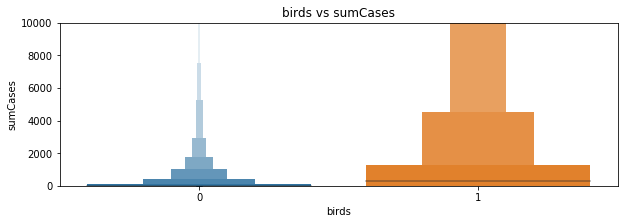

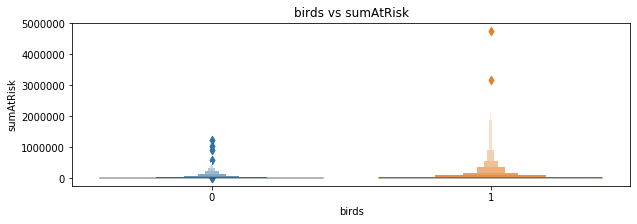

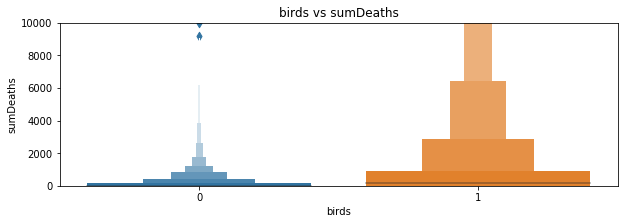

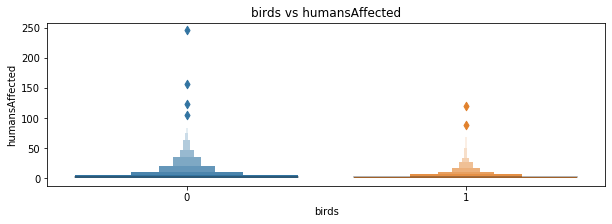

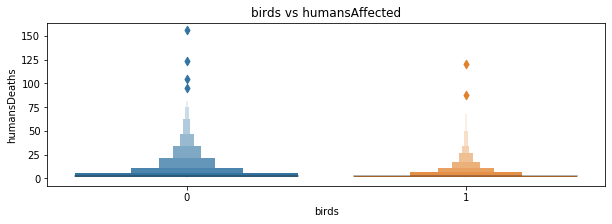

In [45]:
plot_species()

## Discrepancy Between Observation and Reporting Dates

I had assumed that a longer time period between the observationDate and reportingDate would result in a more severe outbreak due to a disease spreading farther without detection, but these visuals show I was incorrect. My believe is that the severity (more deaths and cases) is increased with shorter time periods between these dates because they are more obvious.

In [46]:
def plot_differenceInDays():
    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumCases'])
    plt.title('differenceInDays vs sumCases')
    scatterplot.set_xlim(0, 600)
    plt.show()

    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumAtRisk'])
    plt.title('differenceInDays vs sumAtRisk')
    scatterplot.set_xlim(0, 600)
    plt.show()

    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumDeaths'])
    plt.title('differenceInDays vs sumDeaths')
    scatterplot.set_xlim(0, 600)
    plt.show()

    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['humansAffected'])
    plt.title('differenceInDays vs humansAffected')
    scatterplot.set_xlim(0, 600)
    plt.show()

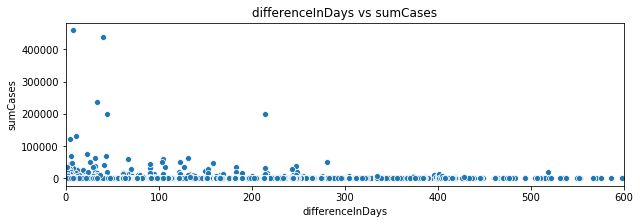

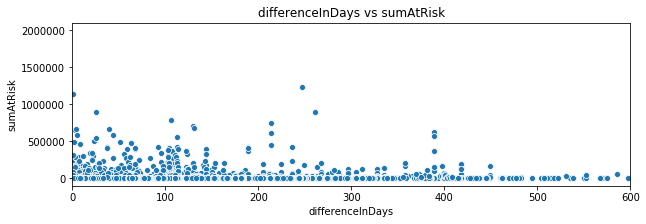

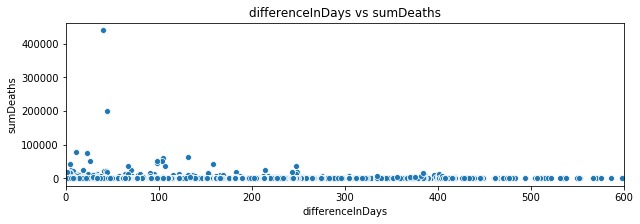

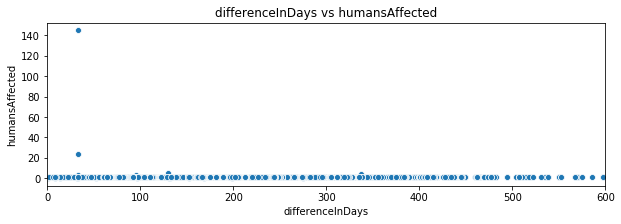

In [47]:
plot_differenceInDays()

## Timing

There does not appear to be a meaningful pattern in outbreaks over the past five years.

In [48]:
def plot_timing():
    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['sumCases'])
    scatterplot.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'))
    plt.title('observationDate vs sumCases')
    plt.show()

    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['sumAtRisk'])
    scatterplot.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'))
    plt.title('observationDate vs sumAtRisk')
    plt.show()

    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['sumDeaths'])
    scatterplot.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'))
    plt.title('observationDate vs sumDeaths')
    plt.show()

    plt.figure(figsize=(10,3))
    scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['humansAffected'])
    scatterplot.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'))
    plt.title('observationDate vs humansAffected')
    plt.show()

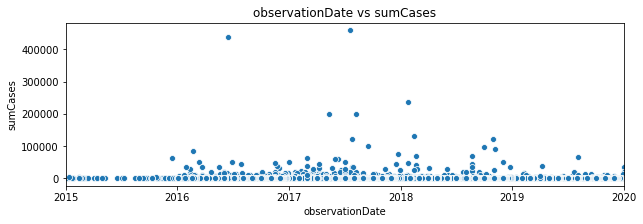

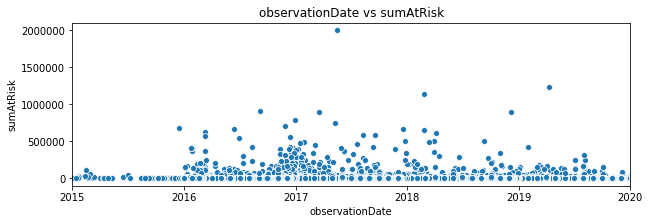

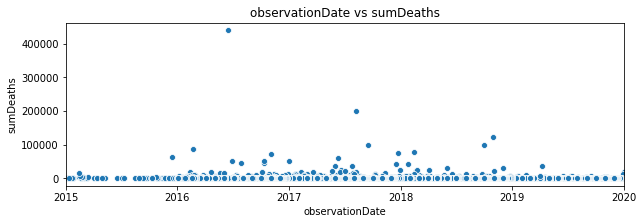

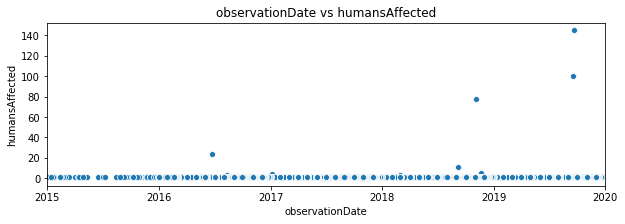

In [49]:
plot_timing()

## Diseases

It's clear that Newcastle disease, Foot and Mouth disease, and Avian Influenza are the most common and deadliest diseases among animals.

In [50]:
top_diseases = outbreaks[(outbreaks['Influenza - Avian'] == 1) | (outbreaks['Bluetongue'] == 1) |
                          (outbreaks['African swine fever'] == 1) | (outbreaks['Lumpy skin disease'] == 1)|
                          (outbreaks['MERS-CoV '] == 1) | (outbreaks['Foot and mouth disease'] == 1)|
                          (outbreaks['Newcastle disease'] == 1) | (outbreaks['Sheep pox and goat pox'] == 1)]

In [51]:
def plot_diseases():
    plt.figure(figsize=(17,8))
    box = sns.boxplot(y='sumCases', x='disease', data=top_diseases)
    plt.title('sumCases vs disease')
    box.set_ylim(0, 2000)
    plt.show()

    plt.figure(figsize=(17,8))
    box = sns.boxplot(y='sumDeaths', x='disease', data=top_diseases)
    plt.title('sumDeaths vs disease')
    box.set_ylim(0, 2000)
    plt.show()

    plt.figure(figsize=(17,8))
    box = sns.boxplot(y='sumSlaughtered', x='disease', data=top_diseases)
    plt.title('sumSlaughtered vs disease')
    box.set_ylim(0, 1000)
    plt.show()
    


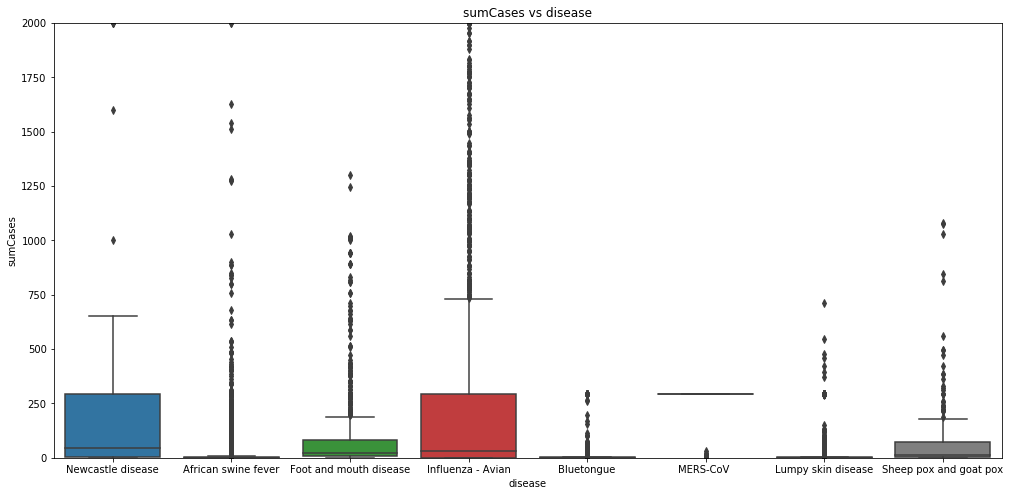

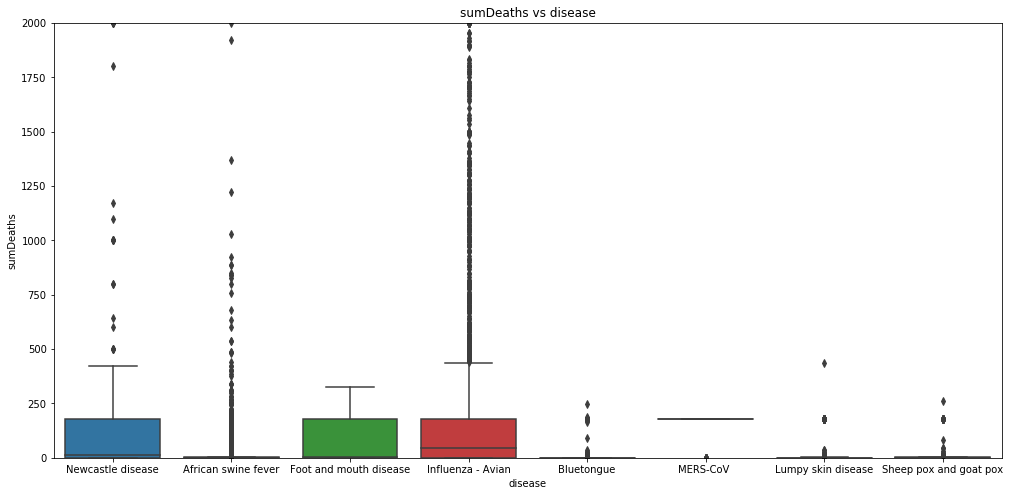

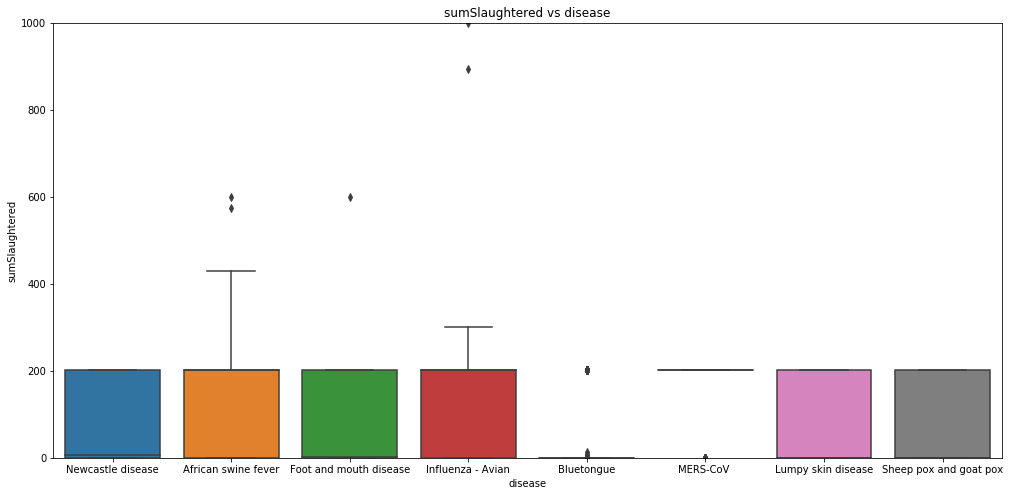

In [52]:
plot_diseases()

## Regions

Europe appears to be the least affected by animal disease outbreaks whereas the Americas appear to be the most affected region.

In [53]:
def plot_regions(): 
    plt.figure(figsize=(10,3))
    box = boxenplot = sns.boxenplot(x=outbreaks['region'], y=outbreaks['sumCases'])
    plt.title('differenceInDays vs sumCases')
    box.set_ylim(0, 10000)
    plt.show()

    plt.figure(figsize=(10,3))
    boxenplot = sns.boxenplot(x=outbreaks['region'], y=outbreaks['sumAtRisk'])
    plt.title('differenceInDays vs sumAtRisk')
    # boxenplot.set_ylim(0, 600)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=outbreaks['region'], y=outbreaks['sumDeaths'])
    plt.title('differenceInDays vs sumDeaths')
    box.set_ylim(0, 10000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=outbreaks['region'], y=outbreaks['humansAffected'])
    plt.title('differenceInDays vs humansAffected')
    # box.set_ylim(0, 10)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=outbreaks['region'], y=outbreaks['humansDeaths'])
    plt.title('differenceInDays vs humansAffected')
    # box.set_ylim(0, 10)
    plt.show()

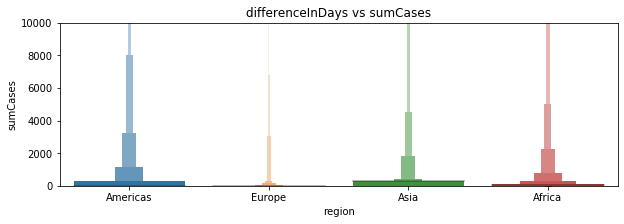

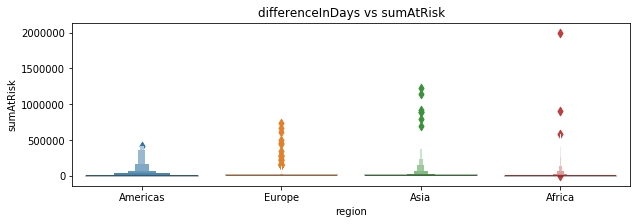

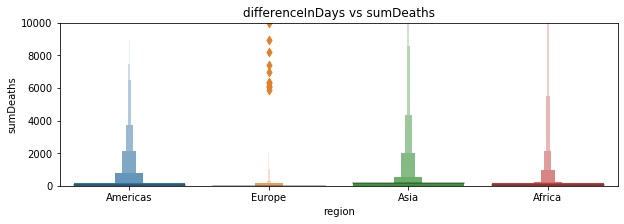

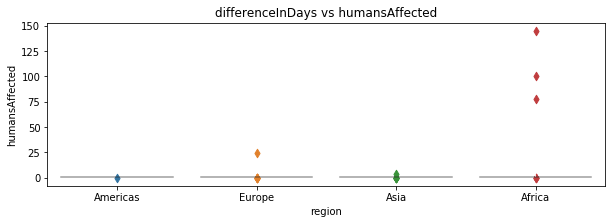

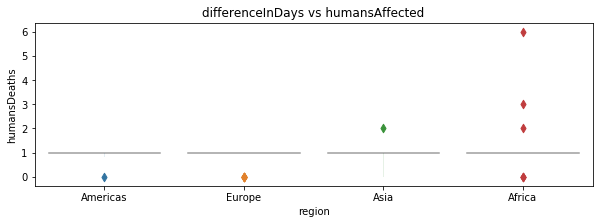

In [54]:
plot_regions()

# Checking Normality and Standardizing Features

The test statistics for both the Jarque-bera and normality tests are very high, indicating the numeric variables are not normal. 

In [523]:
features_to_test = X[['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAge',
                             'humansAffected', 'humansDeaths', 'differenceInDays']]
for feat in features_to_test:
    jb_stats = stats.jarque_bera(outbreaks[feat])
    norm_stats = stats.normaltest(outbreaks[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on sumAtRisk:
Jarque-Bera test statistics for sumAtRisk is 1058916659.9518175 and p value is 0.0
Normality test statistics for sumAtRisk is 70886.09707350767 and p value is 0.0

Testing for normality on sumCases:
Jarque-Bera test statistics for sumCases is 30342330429.314793 and p value is 0.0
Normality test statistics for sumCases is 101453.19851759728 and p value is 0.0

Testing for normality on sumDeaths:
Jarque-Bera test statistics for sumDeaths is 132971161551.42944 and p value is 0.0
Normality test statistics for sumDeaths is 114371.69585736668 and p value is 0.0

Testing for normality on sumDestroyed:
Jarque-Bera test statistics for sumDestroyed is 840207200.4416709 and p value is 0.0
Normality test statistics for sumDestroyed is 71431.01725137612 and p value is 0.0

Testing for normality on sumSlaughtered:
Jarque-Bera test statistics for sumSlaughtered is 20359627578.794685 and p value is 0.0
Normality test statistics for sumSlaughtered is 99718.4030600604

## Normalizing the Variables

I've created a for loop to test the normality of each variable transformed by winsorizing, applying a boxcox, or taking the log or square root. I'll use the transformation which provides the lowest test statistic.

In [524]:
for feat in features_to_test:
    print('Testing Normality for Transformed', feat)
    winsorized_feature = winsorize(X[feat], (0, 0.10))
    print('Normality for winsorize: ', stats.normaltest(winsorized_feature))
    try:
        log_feature = np.log(X[feat])
        print('Normality for log: ', stats.normaltest(log_feature))
    except ValueError:
        print('Log of data cannot be found.')
    try:
        sqrt_feature = np.sqrt(X[feat])
        print('Normality for square root: ', stats.normaltest(sqrt_feature))
    except ValueError:
        print('Square root of data cannot be found.')
    try:
        bc_feature, _ = stats.boxcox(X[feat])
        print('Normality for boxcox: ', stats.normaltest(bc_feature))
    except ValueError:
        print('Data isn\'t positive.')
        print('\n')

Testing Normality for Transformed sumAtRisk
Normality for winsorize:  NormaltestResult(statistic=1179.2835664797503, pvalue=8.35270684675934e-257)
Normality for log:  NormaltestResult(statistic=nan, pvalue=nan)
Normality for square root:  NormaltestResult(statistic=4596.857064324351, pvalue=0.0)
Data isn't positive.
Testing Normality for Transformed sumCases
Normality for winsorize:  NormaltestResult(statistic=1735.4964759972518, pvalue=0.0)
Normality for log:  NormaltestResult(statistic=nan, pvalue=nan)
Normality for square root:  NormaltestResult(statistic=7472.738047640214, pvalue=0.0)
Data isn't positive.
Testing Normality for Transformed sumDeaths
Normality for winsorize:  NormaltestResult(statistic=1381.782330323101, pvalue=8.907982898992153e-301)
Normality for log:  NormaltestResult(statistic=nan, pvalue=nan)
Normality for square root:  NormaltestResult(statistic=7860.772088661301, pvalue=0.0)
Data isn't positive.
Testing Normality for Transformed sumDestroyed
Normality for wins

In [55]:
X['norm_differenceInDays'] = winsorize(X['differenceInDays'], (0, 0.10))
X['norm_sumAtRisk'] = winsorize(X['sumAtRisk'], (0, 0.10))
X['norm_sumCases'] = np.sqrt(X['sumCases'])
X['norm_sumDeaths'] = np.sqrt(X['sumDeaths'])
X['norm_sumDestroyed'] = np.log(X['sumDestroyed'] + 1)
X['norm_sumSlaughtered'] = np.log(X['sumSlaughtered'] + 1)
X['norm_humansAge'] = np.sqrt(X['humansAge'])
X['norm_humansAffected'] = np.sqrt(X['humansAffected'])
X['norm_humansDeaths'] = np.sqrt(X['humansDeaths'])

norm_features = ['norm_differenceInDays', 'norm_sumAtRisk', 'norm_sumCases', 'norm_sumDestroyed', 
                         'norm_sumSlaughtered', 'norm_humansAge', 'norm_humansAffected', 'norm_humansDeaths']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in norm_features:
    jb_stats = stats.jarque_bera(X[feat])
    norm_stats = stats.normaltest(X[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))
    

Testing for normality on norm_differenceInDays:
Jarque-Bera test statistics for norm_differenceInDays is 330.11533349483784 and p value is 0.0
Normality test statistics for norm_differenceInDays is 286.9927412235955 and p value is 4.789807615450258e-63

Testing for normality on norm_sumAtRisk:
Jarque-Bera test statistics for norm_sumAtRisk is 2026.7855670951953 and p value is 0.0
Normality test statistics for norm_sumAtRisk is 1179.2835664797503 and p value is 8.35270684675934e-257

Testing for normality on norm_sumCases:
Jarque-Bera test statistics for norm_sumCases is 1625690.0887427656 and p value is 0.0
Normality test statistics for norm_sumCases is 7472.738047640214 and p value is 0.0

Testing for normality on norm_sumDestroyed:
Jarque-Bera test statistics for norm_sumDestroyed is 586.0311744898255 and p value is 0.0
Normality test statistics for norm_sumDestroyed is 35292.357908380734 and p value is 0.0

Testing for normality on norm_sumSlaughtered:
Jarque-Bera test statistics fo

In [59]:
scaler = StandardScaler()

for feature in norm_features:
    col_name = str(feature+'_std')
    print(col_name)
    X[col_name] = scaler.fit_transform(X[feature].values.reshape(-1,1))

print('\n', X.columns)

norm_differenceInDays_std
norm_sumAtRisk_std
norm_sumCases_std
norm_sumDestroyed_std
norm_sumSlaughtered_std
norm_humansAge_std
norm_humansAffected_std
norm_humansDeaths_std

 Index(['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
       'humansAffected', 'humansDeaths', 'humansAge', 'differenceInDays',
       'observationYear',
       ...
       'norm_humansAffected', 'norm_humansDeaths', 'norm_differenceInDays_std',
       'norm_sumAtRisk_std', 'norm_sumCases_std', 'norm_sumDestroyed_std',
       'norm_sumSlaughtered_std', 'norm_humansAge_std',
       'norm_humansAffected_std', 'norm_humansDeaths_std'],
      dtype='object', length=289)


## Feature Sets

I'll use two sets of features for my analysis. The first will be all the features in the dataset, and the second will consist of variables highly correlated with the normalized humansDeaths variable

In [60]:
corr_mat = X.corr().loc[:, ['norm_humansDeaths_std']].abs().sort_values(by='norm_humansDeaths_std', ascending=False)
pd.options.display.max_rows = None
corr_mat[:70]

,norm_humansDeaths_std
norm_humansDeaths_std,1.000000
norm_humansDeaths,1.000000
norm_humansAffected,0.987573
norm_humansAffected_std,0.987573
humansDeaths,0.940472
humansAffected,0.891057
norm_sumAtRisk,0.548609
norm_sumAtRisk_std,0.548609
sumAtRisk,0.339623
Poland,0.318370


# Visualizations with Dimensionality Reduction

## PCA with All Features
 
 While there are no obvious clusters, my hope is that the datapoints spread to the right will cluster into more severe outbreaks.

In [61]:
# PCA with all variables minus original and normalized/unscaled floats

X_all = X.drop(columns = ['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAge', 'humansAffected', 
                 'humansDeaths', 'differenceInDays', 'norm_differenceInDays', 'norm_sumAtRisk', 'norm_sumCases', 'norm_sumDestroyed', 
                         'norm_sumSlaughtered', 'norm_humansAge', 'norm_humansAffected', 'norm_humansDeaths'])

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
print(pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80= pca_80.fit_transform(X_all)
print(pca_80.explained_variance_ratio_)


[0.87695894 0.09129856]
[0.87695894]


Cluster Graph with PCA 
[0.87695894]


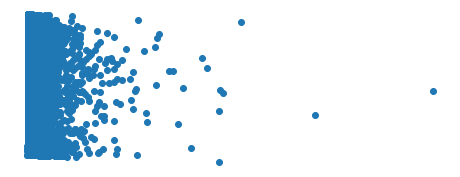

In [62]:
print('Cluster Graph with PCA ')

print(pca_80.explained_variance_ratio_)
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## PCA with humansDeaths Features

First two PCA components:  [0.98823726 0.00322505]
Cluster Graph with PCA 


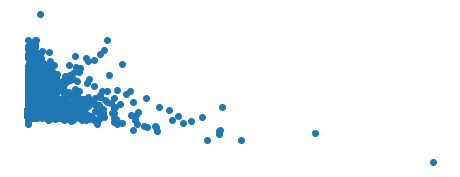

In [64]:
# PCA for features with greater than 0.01 absolute correlation with potential target

X_hd = X[['norm_humansDeaths_std', 'norm_humansAffected_std','Poland','African swine fever',
          'norm_sumSlaughtered_std','Europe','Romania','norm_sumDestroyed_std','wild', 'domestic', '8',
          'norm_humansAge_std','birds','mammals','France','Africa','Bluetongue','Foot and mouth disease',
            'Asia','unspecified','Latvia','Albania','Influenza - Avian','norm_sumDeaths','UnknownSerotypes',
          'Newcastle disease', 'Americas', 'O', 'H7N9 LPAI','Israel', 'Anthrax','4','H5N3 HPAI', 'Serbia',
          'Sheep pox and goat pox','West Nile Fever','Mongolia','observationFirstHalfMonth',
           'Lumpy skin disease','H5N2 LPAI','H5N1 HPAI','South Africa','Greece','United States of America',
         'Equine infectious anaemia','Centroid Locality','SAT2', 'Belgium','Namibia','Brazil','norm_sumCases_std']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
print('First two PCA components: ', pca.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## TSNE with All Variables

This dimensionality reduction technique does not provide anyhting promising.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.215s...
[t-SNE] Computed neighbors for 5831 samples in 3.708s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.654899
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.598785
[t-SNE] KL divergence after 300 iterations: 2.871150
Cluster Graph with t-SNE with Perplexity  10


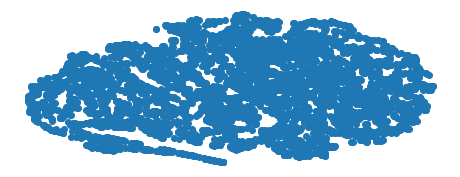

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.191s...
[t-SNE] Computed neighbors for 5831 samples in 4.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.932616
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.658775
[t-SNE] KL divergence after 300 iterations: 2.452583
Cluster Graph with t-SNE with Perplexity  20


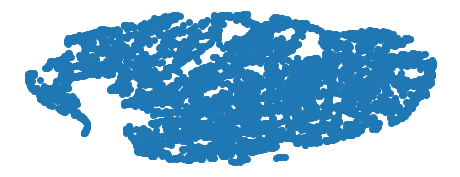

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.257s...
[t-SNE] Computed neighbors for 5831 samples in 6.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 2.098618
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.949265
[t-SNE] KL divergence after 300 iterations: 2.207418
Cluster Graph with t-SNE with Perplexity  30


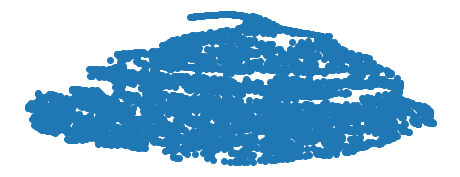

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.092s...
[t-SNE] Computed neighbors for 5831 samples in 3.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 2.222910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.677322
[t-SNE] KL divergence after 300 iterations: 2.023363
Cluster Graph with t-SNE with Perplexity  40


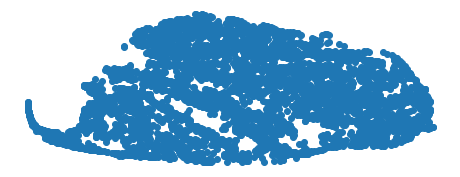

In [353]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_all)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

## TSNE with Top 50 Correlated Variables with humansDeaths

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.041s...
[t-SNE] Computed neighbors for 5831 samples in 1.303s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.493126
[t-SNE] KL divergence after 300 iterations: 2.475347
Cluster Graph with t-SNE with Perplexity  10


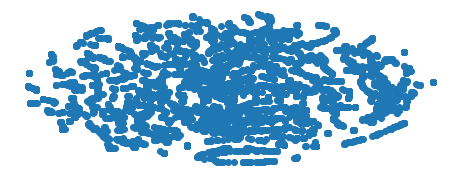

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.035s...
[t-SNE] Computed neighbors for 5831 samples in 1.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.787575
[t-SNE] KL divergence after 300 iterations: 2.064202
Cluster Graph with t-SNE with Perplexity  20


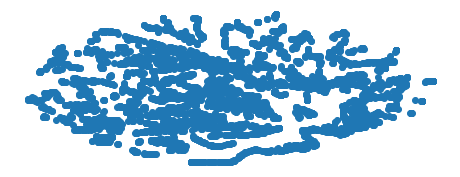

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.069s...
[t-SNE] Computed neighbors for 5831 samples in 1.619s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 0.974702
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.514526
[t-SNE] KL divergence after 300 iterations: 1.823921
Cluster Graph with t-SNE with Perplexity  30


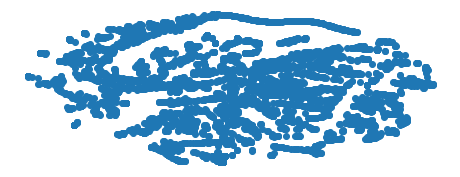

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.048s...
[t-SNE] Computed neighbors for 5831 samples in 1.776s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.067390
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.668068
[t-SNE] KL divergence after 300 iterations: 1.680539
Cluster Graph with t-SNE with Perplexity  40


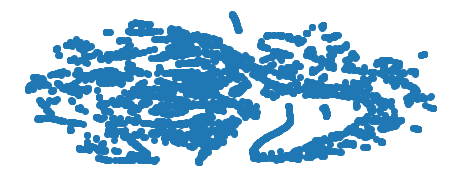

In [355]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_hd)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

## UMAP with All Features

The densest and most separate clusters are with ten neighbors and a minimum distance of 0.1, so I will use these metrics with clustering. 

UMAP with all features. 

UMAP for X_all with  5 neighbors and  0.1 minimum distance.


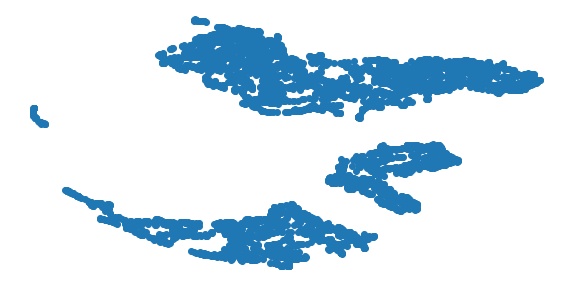



UMAP for X_all with  5 neighbors and  0.25 minimum distance.


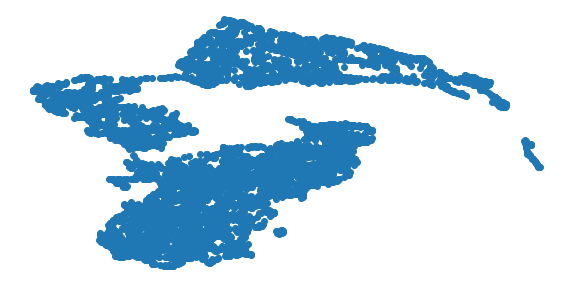



UMAP for X_all with  10 neighbors and  0.1 minimum distance.


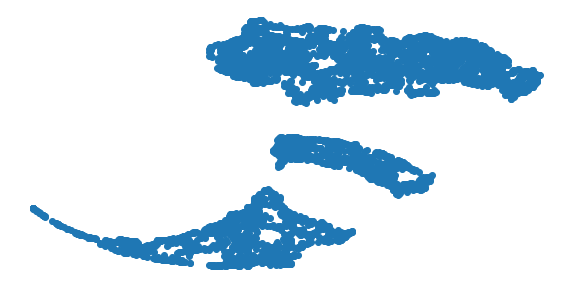



UMAP for X_all with  10 neighbors and  0.25 minimum distance.


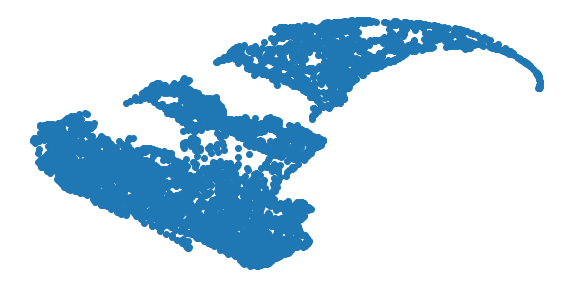

In [356]:
# UMAP with all features
print('UMAP with all features. \n')
for n_neighbors in [5, 10]:
    for min_dist in [0.1, 0.25]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X_all)
        print('UMAP for X_all with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

## UMAP with Features Highly Correlated with humansDeaths

The separation isn't great, but using 30 neighbors with a minimum distance of 0.25 seems to provide the densest, most separate clusters.

UMAP with  20 neighbors and  0.25 minimum distance.


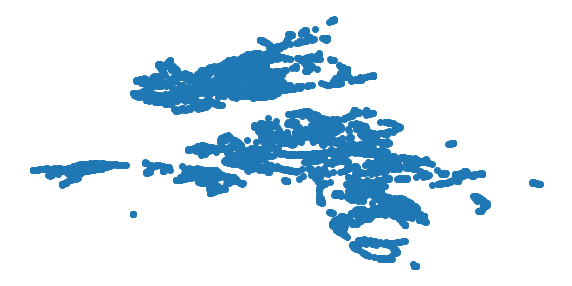



UMAP with  30 neighbors and  0.25 minimum distance.


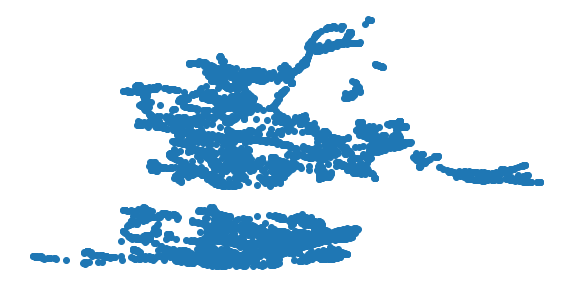



UMAP with  40 neighbors and  0.25 minimum distance.


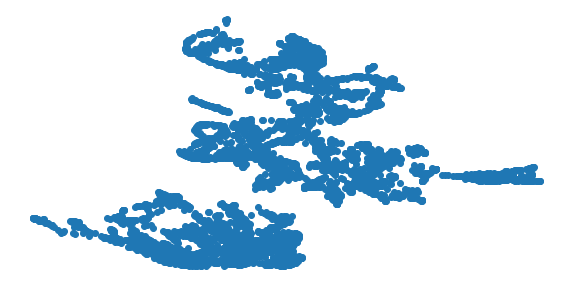

In [357]:
# UMAP with higher correlation with humansDeaths
for n_neighbors in [20, 30, 40]:
    for min_dist in [0.25]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X_hd)
        print('UMAP with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

## Locally Linear Embedding 

I thought I'd try another dimensionality reduction technique just for fun. LLE provided nothing of interest, indicating our data may in fact have a linear quality.

LLE with  5 neighbors and two components.


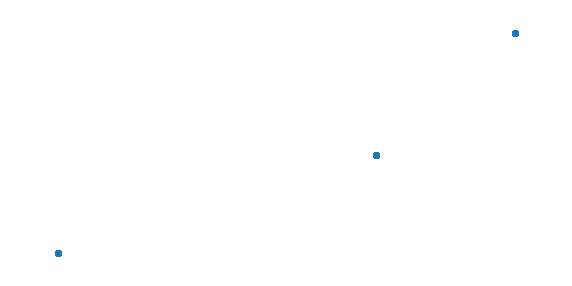



LLE with  10 neighbors and two components.


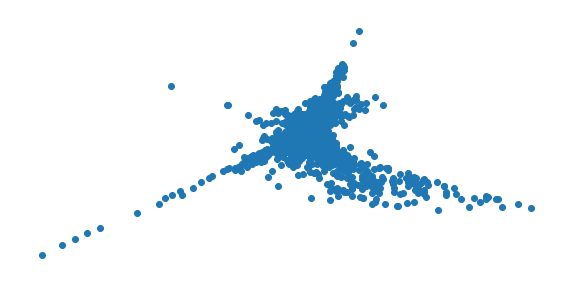



LLE with  25 neighbors and two components.


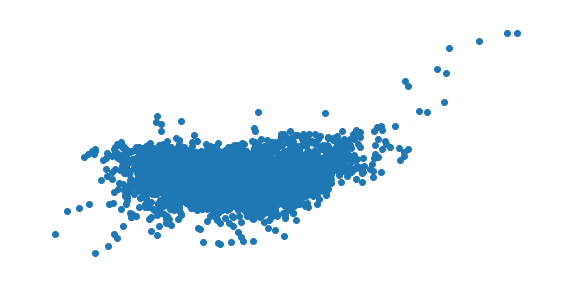



LLE with  50 neighbors and two components.


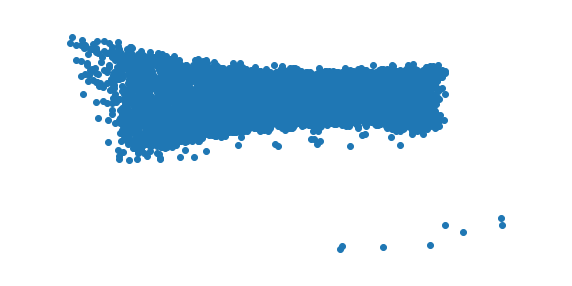

In [196]:
# LLE with all features
for n_neighbors in [5, 10, 25, 50]:
    lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=n_neighbors,
                    eigen_solver='dense').fit_transform(X_all)
    print('LLE with ', n_neighbors, 'neighbors and two components.')
    plt.figure(figsize=(10,5))
    plt.scatter(lle_results[:, 0], lle_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()
    print('\n')


LLE with  5 neighbors and two components.


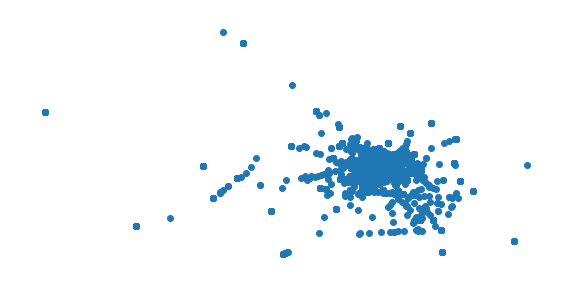



LLE with  10 neighbors and two components.


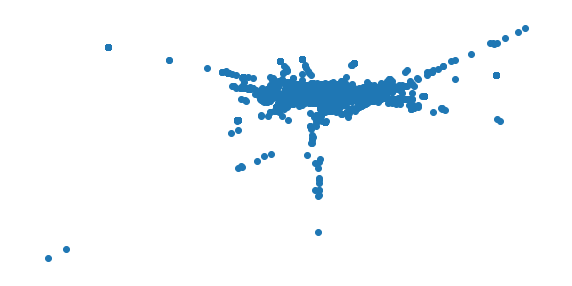



LLE with  25 neighbors and two components.


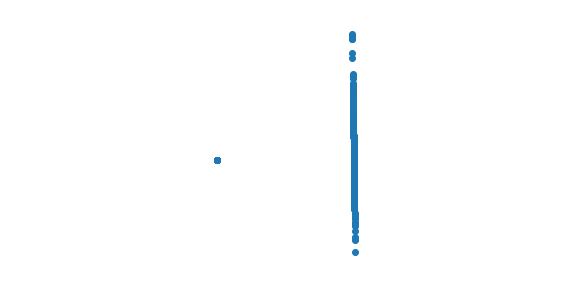



LLE with  50 neighbors and two components.


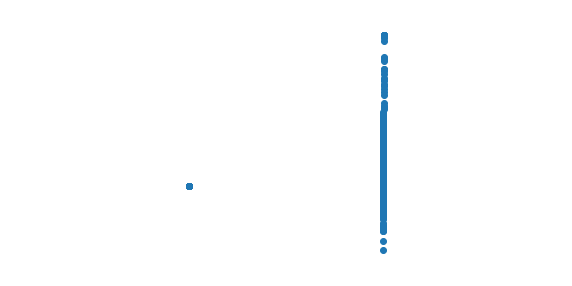

In [197]:
# LLE with humansDeaths features
for n_neighbors in [5, 10, 25, 50]:
    lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=n_neighbors,
                    eigen_solver='dense').fit_transform(X_hd)
    print('LLE with ', n_neighbors, 'neighbors and two components.')
    plt.figure(figsize=(10,5))
    plt.scatter(lle_results[:, 0], lle_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()
    print('\n')

# Functions to Add Cluster Labels

For each clustering technique, I'll create a function to run it. I'll use lists and dictionaries to compare parameters (cluster numbers, eps, etc.), so I've also created a function (getKeysByValue) that will allow me to obtain a dictionary key by its value. Additionally, I've created two functions that will obtain the p-values for all variables once clusters have been assigned. One will be used when a clustering technique provides two clusters, and the other for three. 

In [65]:
# Get a list of keys from dictionary which has the given value

def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

import operator

def get_pvalue_2clusters(variables):
    variables_pvalues = {}
    for variable in variables:
        t, pvalue = stats.ttest_ind(group_0[[variable]], group_1[[variable]])
        variables_pvalues[variable] = pvalue
    sorted_variables_pvalues = sorted(variables_pvalues.items(), key=operator.itemgetter(1))
    for variable, pvalue in sorted_variables_pvalues:
        print(variable, ':', pvalue)

def get_pvalue_3clusters(variables):
    variables_pvalues = {}
    for variable in variables:
        stat, pvalue = stats.f_oneway(group_0[[variable]], group_1[[variable]], group_2[[variable]])
        variables_pvalues[variable] = pvalue
    sorted_variables_pvalues = sorted(variables_pvalues.items(), key=operator.itemgetter(1))
    for variable, pvalue in sorted_variables_pvalues:
        print(variable, ':', pvalue)


# Clustering

## K-means Function

All functions will be able to use data with either PCA or UMAP components and additional parameters when needed. They will iterate through a set number of clusters (or other parameter), graph the silhouette scores, and plot the clusters when able. I have also chosen to show the Davies Bouldin index as another clustering metric to compare.

In [66]:
def kmeans_clustering(df, dr_technique, **params):
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    silhouettes_list = []
    silhouettes_dict = {} # silhoutte scores are keys, clusters are values
    dbs = []      
       
   
    if dr_technique=='PCA':
        pca = PCA(n_components=2)
        components = pca.fit_transform(df)
       
    elif dr_technique=='UMAP': 
        parameters = list(params.keys())
        number_of_neighbors = params[parameters[0]]
        min_distance = params[parameters[1]]
        components = umap.UMAP(n_neighbors=number_of_neighbors, min_dist=min_distance, metric='correlation').fit_transform(df)

    # looping through cluster numbers to find the best cluster
    for cluster in clusters:
        labels = KMeans(n_clusters=cluster, random_state=123).fit_predict(components)
        kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
        y_pred = kmeans_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_list.append(silhouette)
        silhouettes_dict[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)

    # plotting the silhouette scores
    plt.title('Silhouette Scores for Number of Clusters')  
    plt.scatter(list(silhouettes_dict.keys()), list(silhouettes_dict.values()))
    plt.show()


    best_cluster = getKeysByValue(silhouettes_dict, max(silhouettes_list))
    best_cluster_dbi = metrics.davies_bouldin_score(components,  KMeans(n_clusters=best_cluster[0], random_state=123).fit_predict(components))
    print('Best Silhouette score is {} with {} clusters. '.format( silhouettes_dict[best_cluster[0]],best_cluster[0]))
    print('Best Davies Bouldin score: ', min(dbs))   
    # plotting the clusters with the best silhouette score
    labels = KMeans(n_clusters=best_cluster[0], random_state=123).fit_predict(components)
    kmeans_cluster = KMeans(n_clusters=best_cluster[0], random_state=123)
    y_pred = kmeans_cluster.fit_predict(components)
       
    plt.title('K-Means Clustering for {} Clusters with Davies Bouldin Index {}'.format(best_cluster[0], best_cluster_dbi))
    plt.scatter(components[:,0], components[:,1], c=y_pred)
    plt.show()
    



## K-Means with PCA Components for all features

The best silhouette score is 0.78 with two clusters. 

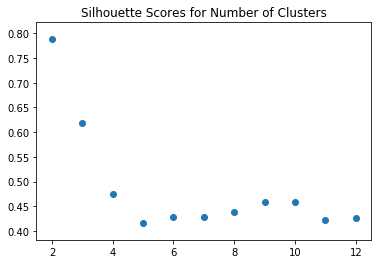

Best Silhouette score is 0.7884521879014621 with 2 clusters. 
Best Davies Bouldin score:  0.5958888202644814


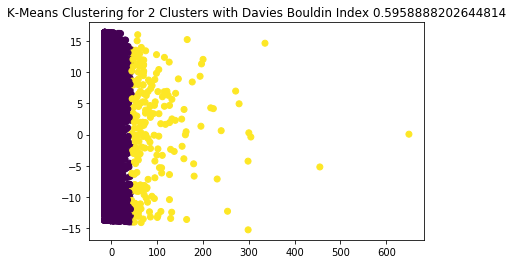

In [67]:
kmeans_clustering(X_all, 'PCA')

## K-Means using PCA for features with high correlations with humansDeaths

Similarly, the highest silhouette score is 0.837 for two clusters, and the Davies Boulding index has decreased to 0.43.

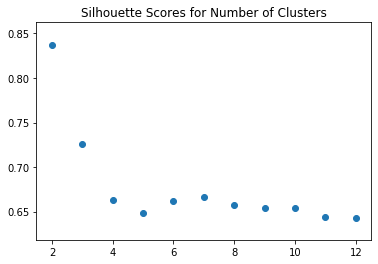

Best Silhouette score is 0.8375601424339016 with 2 clusters. 
Best Davies Bouldin score:  0.43401288618692796


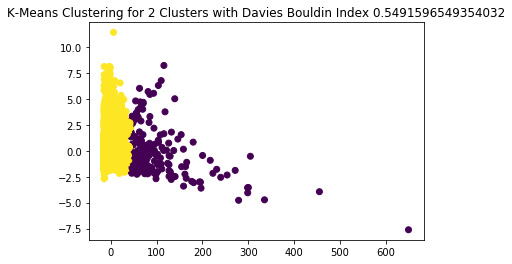

In [374]:
kmeans_clustering(X_hd, 'PCA')

## K-Means using UMAP for all features

The silhouette score has decreased to 0.62 and the DB index has increased to 0.57, with two clusters still performing best.

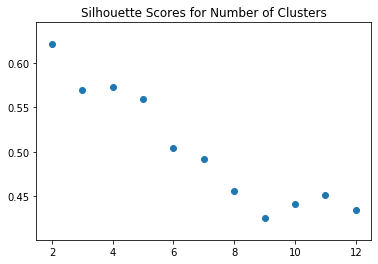

Best Silhouette score is 0.6209039092063904 with 2 clusters. 
Best Davies Bouldin score:  0.5765824737979379


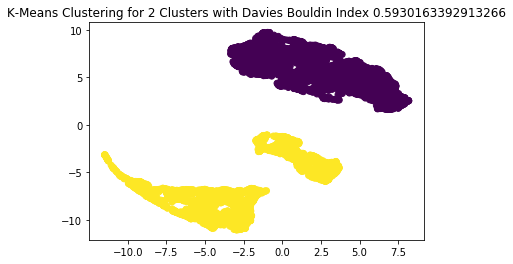

In [375]:
kmeans_clustering(X_all, 'UMAP', neighbors=10, min_distance=0.1)

## K-Means using UMAP for features with high correlations with humansDeaths

The lowest silhouette score at 0.518 and highest DB index at 0.675, this is the worst performer so far.

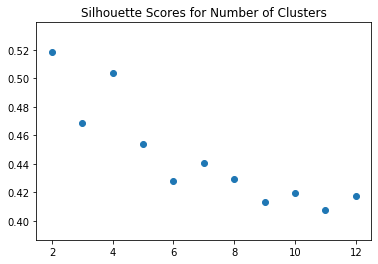

Best Silhouette score is 0.5185441970825195 with 2 clusters. 
Best Davies Bouldin score:  0.6750282641104685


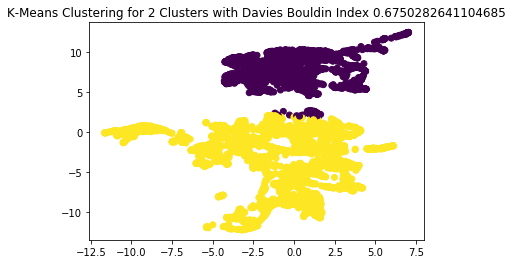

In [532]:
kmeans_clustering(X_hd, 'UMAP', neighbors=30, min_distance=0.25)

# P-Values for Labeled Features

For each round of clustering, I will assign cluster labels to the highest performer, find the p-values between clusters, and graph the results. In this round, using PCA components for the features highly correlated with humansDeaths was the top performer.

In [68]:
# K-means with humansDeaths features

pca = PCA(n_components=2)
components = pca.fit_transform(X_hd)

labels = KMeans(n_clusters=2, random_state=123).fit_predict(components)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_hd_pca_kmeans_clusters'] = labels
group_0 = X[X['X_hd_pca_kmeans_clusters'] == 0]
group_1 = X[X['X_hd_pca_kmeans_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 289)
5831
{0: 241, 1: 5590}
norm_sumCases : [0.]
norm_sumDeaths : [0.]
norm_sumCases_std : [0.]
X_hd_pca_kmeans_clusters : [0.]
sumDeaths : [7.25058468e-225]
sumCases : [1.24928268e-131]
norm_sumAtRisk_std : [1.06104481e-126]
norm_sumAtRisk : [1.06104481e-126]
sumAtRisk : [4.39273437e-124]
Influenza - Avian : [3.11824333e-89]
birds : [3.21533342e-87]
sumDestroyed : [8.60791427e-83]
Iraq : [2.85287392e-80]
mammals : [7.83324838e-72]
norm_sumDestroyed_std : [5.65412508e-67]
norm_sumDestroyed : [5.65412508e-67]
unspecified : [3.14554522e-57]
H7N9 LPAI : [2.86663167e-46]
UnknownSerotypes : [5.45268212e-45]
H7N9 HPAI : [8.5056321e-38]
H5N2 HPAI : [5.15513296e-37]
Taiwan (Province of China) : [1.06913826e-33]
Asia : [4.25600107e-31]
China : [3.48041906e-26]
Europe : [8.01838478e-21]
H5N8 HPAI : [8.51561056e-21]
norm_humansDeaths_std : [4.41794805e-18]
norm_humansDeaths : [4.41794805e-18]
norm_humansAffected : [2.06173997e-17]
norm_humansAffected_std : [2.06173997e-17]
Togo : [5.900977

In [69]:
def plot_hd_pca_kmeans_clusters():
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['sumCases'])
    plt.title('K-Means Clusters vs sumCases (p-value = 1.249e-131)')
    box.set_ylim(0, 100000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['sumDeaths'])
    plt.title('K-Means Clusters vs sumDeaths (p-value = 7.251e-225)')
    box.set_ylim(0, 50000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['humansAffected'])
    plt.title('K-Means Clusters vs humansAffected (p-value = 3.181e-14)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['humansDeaths'])
    plt.title('K-Means Clusters vs humansDeaths (p-value = 4.422e-16)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['Africa'])
    plt.title('K-Means Clusters vs Africa (p-value = 0.085)')
    plt.show()
    
    plt.figure(figsize=(10,3))
    sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['Americas'])
    plt.title('K-Means Clusters vs Americas (p-value = 0.509)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['Asia'])
    plt.title('K-Means Clusters vs Asia (p-value = 4.256e-31)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['Europe'])
    plt.title('K-Means Clusters vs Europe (p-value = 8.018e-21)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['African swine fever'])
    plt.title('K-Means Clusters vs African swine fever (p-value = 4.431e-16)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['Foot and mouth disease'])
    plt.title('K-Means Clusters vs Foot and mouth disease (p-value = 1.516e-7)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['Influenza - Avian'])
    plt.title('K-Means Clusters vs Influenza - Avian (p-value = 3.118e-89)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['UnknownSerotypes'])
    plt.title('K-Means Clusters vs UnknownSerotypes (p-value = 5.452e-45)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['birds'])
    plt.title('K-Means Clusters vs birds (p-value = 3.215e-87)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['mammals'])
    plt.title('K-Means Clusters vs mammals (p-value = 7.883e-72)')
    plt.show()
    
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_pca_kmeans_clusters'], y=X['wild'])
    plt.title('K-Means Clusters vs wild (p-value = 8.065e-11)')
    plt.show()



## K-Means Cluster Labels (humansDeaths features, PCA components)

For all clusters, I will look at sumCases, sumDeaths, humansAffected, humansDeaths, regions, most common diseases, and animal factors.

This K-means clustered the numeric variables and the categorical variables separately. I'm not sure why or how as this would indicate to me that severe outbreaks are completely uncorrelated with region, animal class, or disease. While this may be possible, I think it's unlikely. I'm curious to see what the other clustering techniques provide as K-means with PCA components from humansDeaths features gave little information.


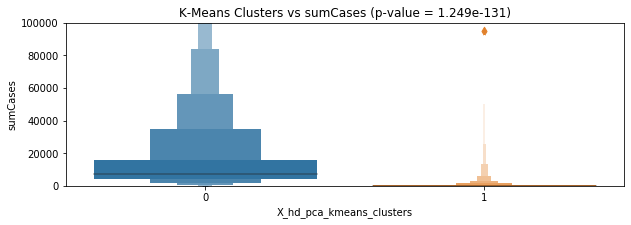

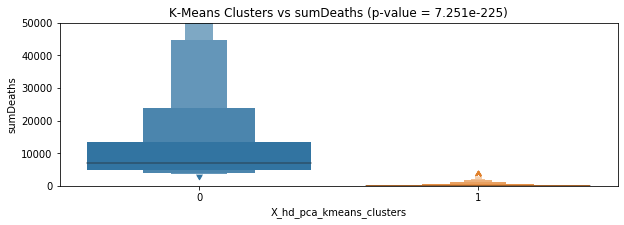

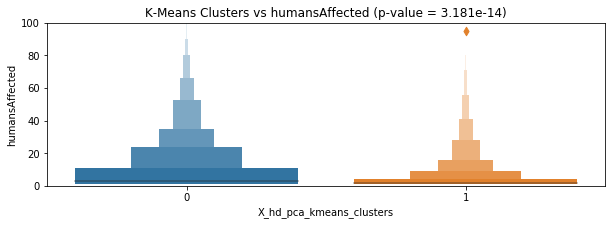

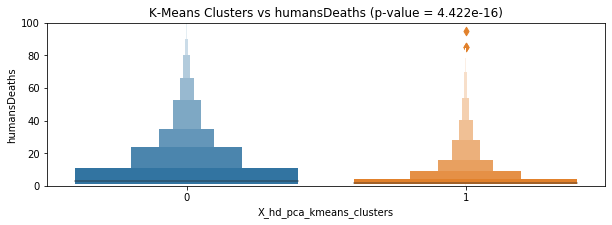

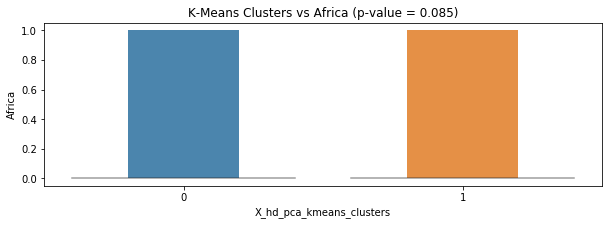

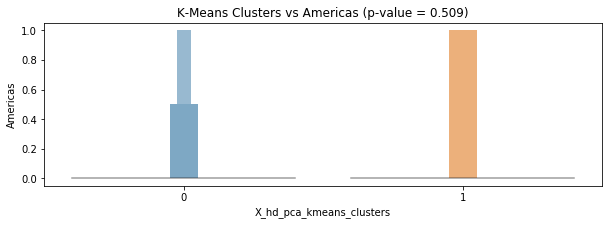

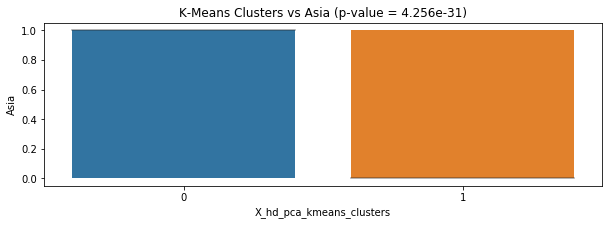

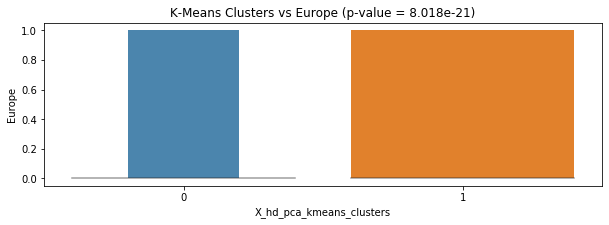

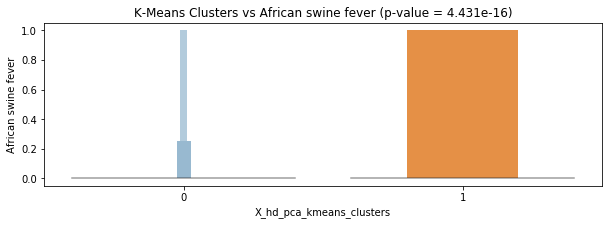

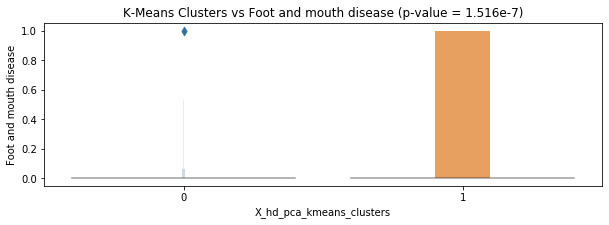

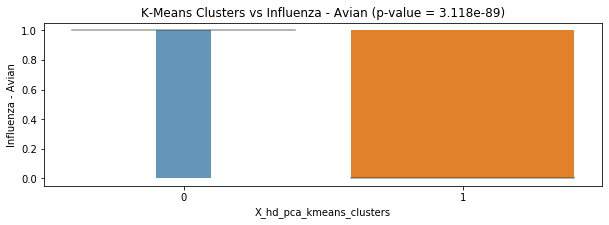

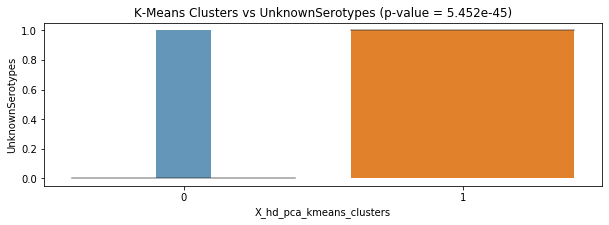

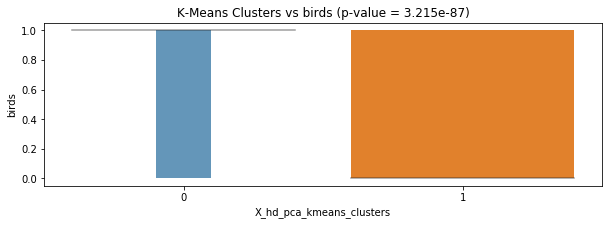

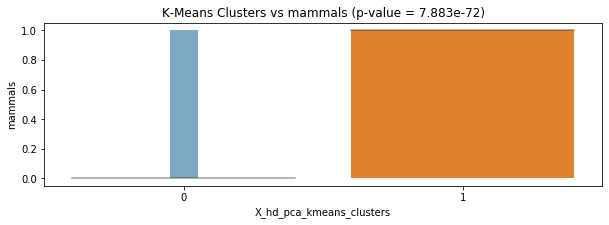

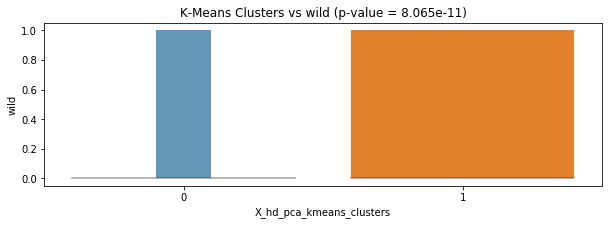

In [71]:
plot_hd_pca_kmeans_clusters()

In [72]:
# K-means with all features with UMAP components

umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)

labels = KMeans(n_clusters=2, random_state=123).fit_predict(umap_results)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_all_umap_kmeans_clusters'] = labels
group_0 = X[X['X_all_umap_kmeans_clusters'] == 0]
group_1 = X[X['X_all_umap_kmeans_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 290)
5831
{0: 2367, 1: 3464}
norm_sumDeaths : [0.]
norm_sumDestroyed : [0.]
norm_sumDestroyed_std : [0.]
X_all_umap_kmeans_clusters : [0.]
norm_sumSlaughtered : [2.17395953e-217]
norm_sumSlaughtered_std : [2.17395953e-217]
norm_sumCases : [9.95656919e-196]
norm_sumCases_std : [9.95656919e-196]
Europe : [2.06333069e-157]
Asia : [7.95279822e-152]
mammals : [2.44497771e-123]
OIE : [5.19726207e-111]
National authorities : [4.16577024e-99]
X_hd_pca_kmeans_clusters : [1.33878906e-84]
Influenza - Avian : [5.81185612e-73]
Saudi Arabia : [1.5879265e-69]
MERS-CoV  : [8.68482162e-69]
wild : [8.86332361e-69]
African swine fever : [1.35689183e-62]
norm_sumAtRisk_std : [3.31428199e-60]
norm_sumAtRisk : [3.31428199e-60]
H5N1 HPAI : [2.85674175e-57]
birds : [4.19915613e-53]
humansAge : [1.03521703e-51]
Centroid Admin1 : [1.48595718e-43]
UnknownSerotypes : [2.31044456e-40]
Centroid Admin2 : [7.59486494e-40]
norm_humansAge_std : [7.38020593e-36]
norm_humansAge : [7.38020593e-36]
H5N2 HPAI : [4.83

In [73]:
def plot_all_umap_kmeans_clusters():
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['sumCases'])
    plt.title('K-Means Clusters vs sumCases (p-value = 4.634e-26)')
    box.set_ylim(0, 100000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['sumDeaths'])
    plt.title('K-Means Clusters vs sumDeaths (p-value = 2.403e-25)')
    box.set_ylim(0, 50000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['humansAffected'])
    plt.title('K-Means Clusters vs humansAffected (p-value = 2.19e-108)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['humansDeaths'])
    plt.title('K-Means Clusters vs humansDeaths (p-value = 7.25e-116)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['Africa'])
    plt.title('K-Means Clusters vs Africa (p-value = 4.74e-224)')
    plt.show()

    plt.figure(figsize=(10,3))
    sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['Americas'])
    plt.title('K-Means Clusters vs Americas (p-value = 6.63e-30)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['Asia'])
    plt.title('K-Means Clusters vs Asia (p-value = 7.952-152)')
    plt.show()
    
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['Europe'])
    plt.title('K-Means Clusters vs Europe (p-value = 2.063e-157)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['African swine fever'])
    plt.title('K-Means Clusters vs African swine fever (p-value = 1.356e-62)')
    plt.show()
    

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['Foot and mouth disease'])
    plt.title('K-Means Clusters vs Foot and mouth disease (p-value = 0.002)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['Influenza - Avian'])
    plt.title('K-Means Clusters vs Influenza - Avian (p-value = 5.811e-73)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['UnknownSerotypes'])
    plt.title('K-Means Clusters vs UnknownSerotypes (p-value = 2.310e-40)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['birds'])
    plt.title('K-Means Clusters vs birds (p-value = 4.199e-53)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['mammals'])
    plt.title('K-Means Clusters vs mammals (p-value = 2.444e-123)')
# box.set_ylim(0, 10)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_kmeans_clusters'], y=X['wild'])
    plt.title('K-Means Clusters vs wild (p-value = 8.863e-69)')
    plt.show()


## K-Means Cluster Labels (All features, UMAP components)

This model clusters sumCases and sumDeaths separately from humansAffected and humansDeaths, indicating that outbreaks severe to animals may be different than those severe to humans. Outbreaks in Asia and of the Avian influenza were more closely correlated with outbreaks high in animal cases and deaths, where as those affecting wild animals, as opposed to domestic, and of the African Swine flu were more likely to be found in clusters containing higher humansAffected and humansDeaths rates.

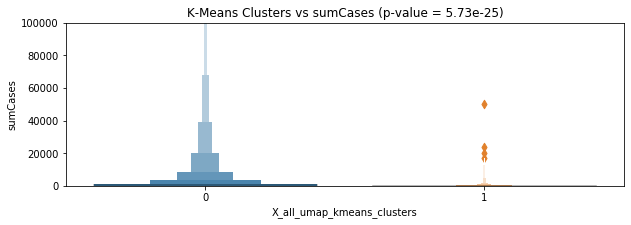

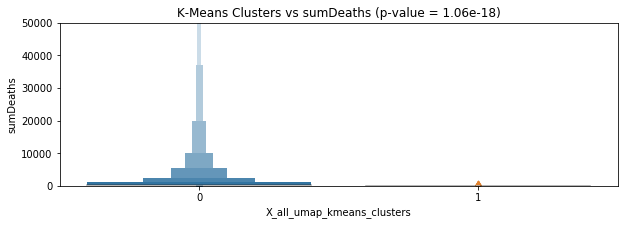

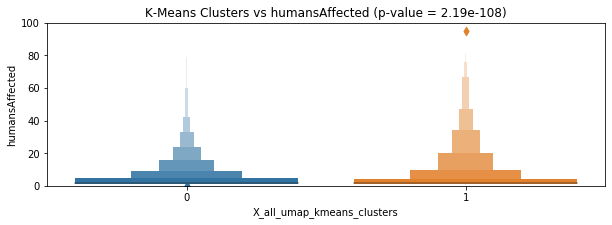

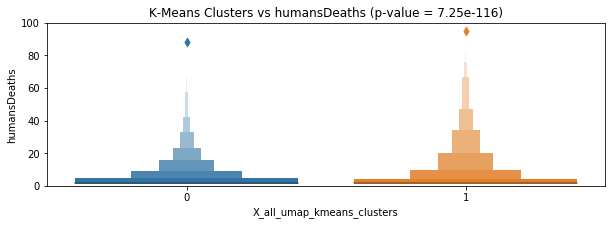

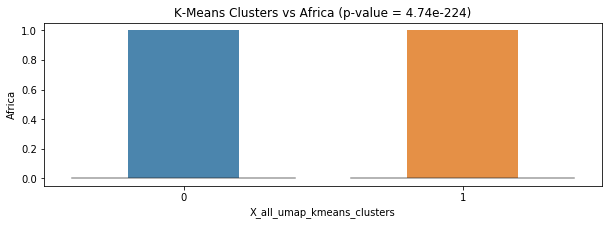

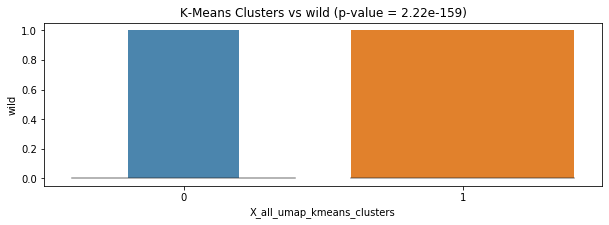

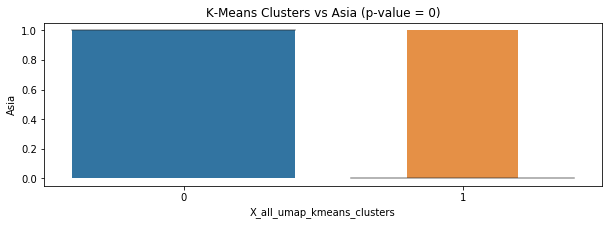

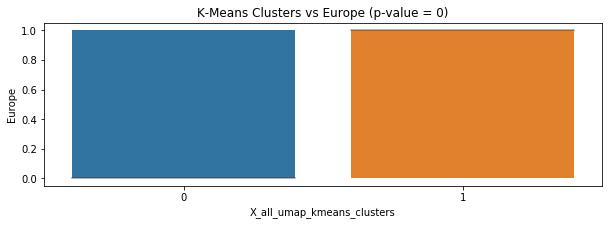

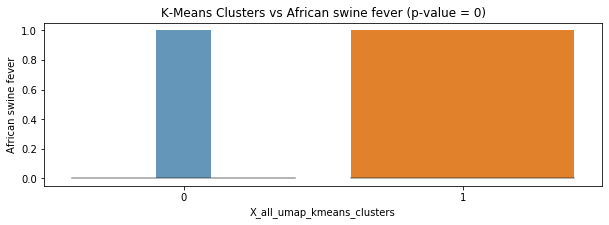

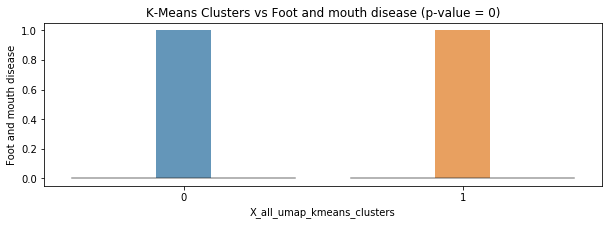

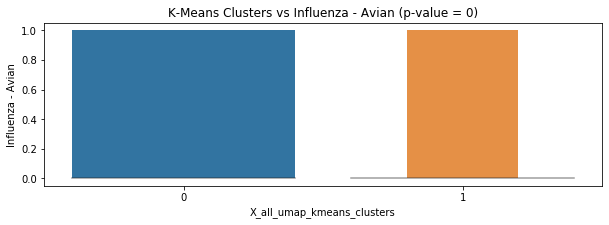

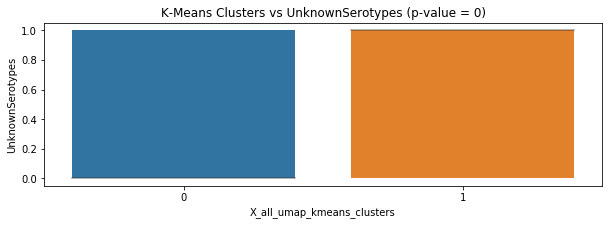

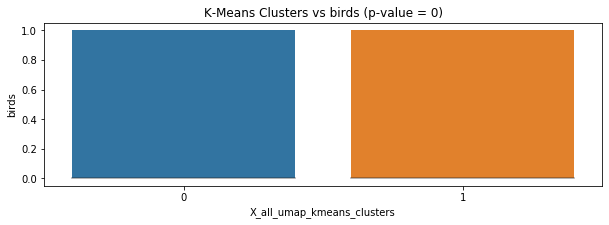

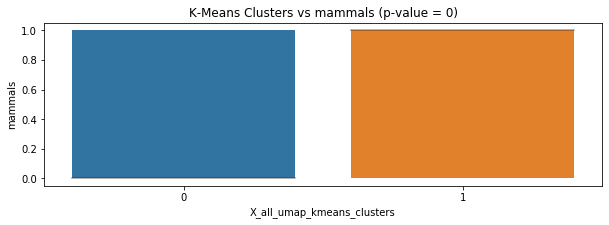

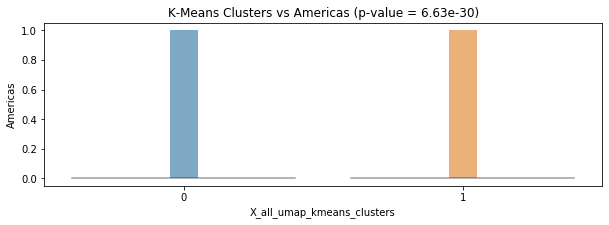

In [560]:
plot_all_umap_kmeans_clusters()

## Agglomerative Clustering for all features with PCA Components

In [75]:
def agglomerative_clustering(df, dr_technique, **params):
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    dbs = []      
       

    if dr_technique=='PCA':
        pca = PCA(n_components=2)
        components = pca.fit_transform(df)
       
    elif dr_technique=='UMAP': 
        parameters = list(params.keys())
        number_of_neighbors = params[parameters[0]]
        min_distance = params[parameters[1]]
        components = umap.UMAP(n_neighbors=number_of_neighbors, min_dist=min_distance, metric='correlation').fit_transform(df)

    # looping through cluster numbers to find the best cluster
    silhouettes_ward = {} # clusters are keys, silhoutte scores are values
    silhouettes_ward_list = []
    for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='ward',
                                      affinity='euclidean',
                                      n_clusters=cluster)
        labels = agg_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_ward_list.append(silhouette)
        silhouettes_ward[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)
        
     
    silhouettes_complete = {} # silhoutte scores are keys, clusters are values
    silhouettes_complete_list = []
    for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='complete',
                                      affinity='euclidean',
                                      n_clusters=cluster)
        labels = agg_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_complete_list.append(silhouette)
        silhouettes_complete[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)
       
    silhouettes_average = {} # silhoutte scores are keys, clusters are values
    silhouettes_average_list = []
    for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='average',
                                      affinity='euclidean',
                                      n_clusters=cluster)
        labels = agg_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_average_list.append(silhouette)
        silhouettes_average[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)
       
    best_ward_cluster = getKeysByValue(silhouettes_ward, max(silhouettes_ward_list))
    best_ward_cluster = best_ward_cluster[0]
    best_complete_cluster = getKeysByValue(silhouettes_complete, max(silhouettes_complete_list))
    best_complete_cluster = best_complete_cluster[0]
    best_average_cluster = getKeysByValue(silhouettes_average, max(silhouettes_average_list))
    best_average_cluster = best_average_cluster[0]
    # plotting the silhouette scores
    plt.title('Silhouette Scores for Number of Clusters')  
    plt.scatter(list(silhouettes_ward.keys()), list(silhouettes_ward.values()), color='blue')
    plt.scatter(list(silhouettes_complete.keys()), list(silhouettes_complete.values()), color='green')
    plt.scatter(list(silhouettes_average.keys()), list(silhouettes_average.values()), color='red')
    plt.show()

    print('Best Silhouette score with ward linkage is {} with {} clusters. '.format(silhouettes_ward[best_ward_cluster], best_ward_cluster))
    print('Best Silhouette score with complete linkage is {} with {} clusters. '.format(silhouettes_complete[best_complete_cluster], best_complete_cluster))
    print('Best Silhouette score with average linkage is {} with {} clusters. '.format(silhouettes_average[best_average_cluster], best_average_cluster))
    print('Best Davies Bouldin score: ', min(dbs))
        


## Agglomerative Clustering for All Features with PCA Components

While we see extremely high silhouette scores of 0.95 with complete and average linkage, it's obvious they are so high because they're isolating a very small portion of the data. When this happens, we'll use a more moderate parameter/metric combination, in this case the ward linkage with a silhouette score of 0.77 with two clusters, for the model.

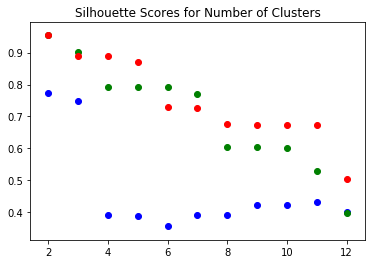

Best Silhouette score with ward linkage is 0.7730616369969872 with 2 clusters. 
Best Silhouette score with complete linkage is 0.9546866611146686 with 2 clusters. 
Best Silhouette score with average linkage is 0.9546866611146686 with 2 clusters. 
Best Davies Bouldin score:  0.20654770386665489


In [387]:
agglomerative_clustering(X_all, 'PCA')

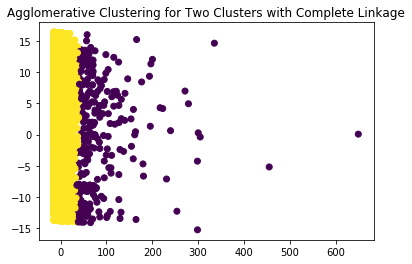

Silhouette Score:  0.7730616369969872
Davies Bouldin Index:  0.6211473325824834


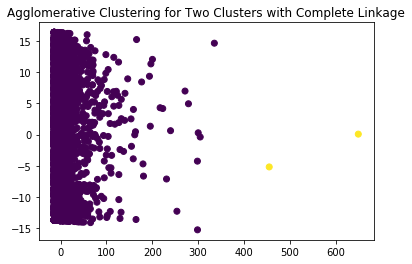

Silhouette Score:  0.9546866611146686
Davies Bouldin Index:  0.20654770386665494


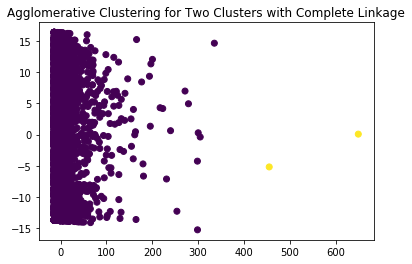

Silhouette Score:  0.9546866611146686
Davies Bouldin Index:  0.20654770386665514


In [388]:
# plotting the clusters with the best silhouette score
for link in ['ward', 'complete', 'average']:
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X_all)
    agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=2)
    cluster_labels = agg_cluster.fit_predict(pca_components)

    plt.title('Agglomerative Clustering for Two Clusters with Complete Linkage')
    plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
    plt.show()

    print('Silhouette Score: ', metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean'))
    print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, cluster_labels))

## Agglomerative Clustering for humansDeaths features with PCA Components

Again, while complete and average linkage provide impressive silhouette scores, it is only because they are isolating data. We'll proceed with the ward score of 0.83, thought the dendrogram shows that the clusters differ in size quite a bit.

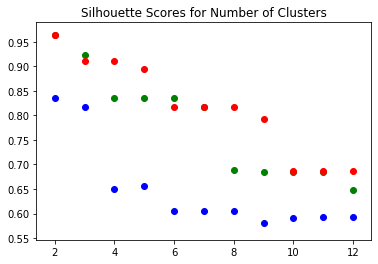

Best Silhouette score with ward linkage is 0.8358474807528357 with 2 clusters. 
Best Silhouette score with complete linkage is 0.963338050947044 with 2 clusters. 
Best Silhouette score with average linkage is 0.963338050947044 with 2 clusters. 
Best Davies Bouldin score:  0.20088148071471118


In [76]:
agglomerative_clustering(X_hd, 'PCA')

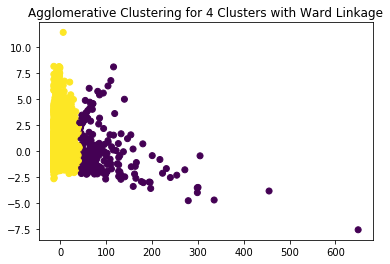

Silhouette Score:  0.8358474807529781
Davies Bouldin Index:  0.5521942461996534


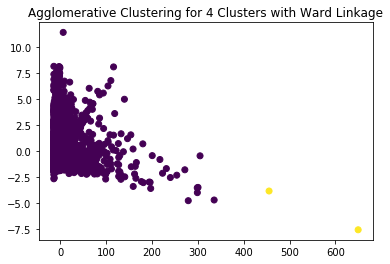

Silhouette Score:  0.9633380509470598
Davies Bouldin Index:  0.20088148071472778


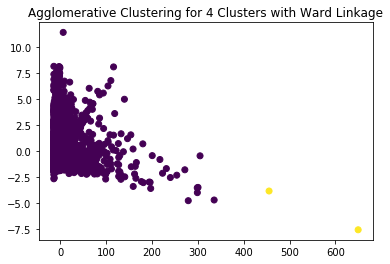

Silhouette Score:  0.963338050947044
Davies Bouldin Index:  0.20088148071471587


In [78]:
# plotting the clusters with the best silhouette score
for link in ['ward', 'average', 'complete']:
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X_hd)
    agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=2)
    cluster_labels = agg_cluster.fit_predict(pca_components)

    plt.title('Agglomerative Clustering for {} Clusters with Ward Linkage'.format(cluster))
    plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
    plt.show()

    print('Silhouette Score: ', metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean'))
    print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, cluster_labels))

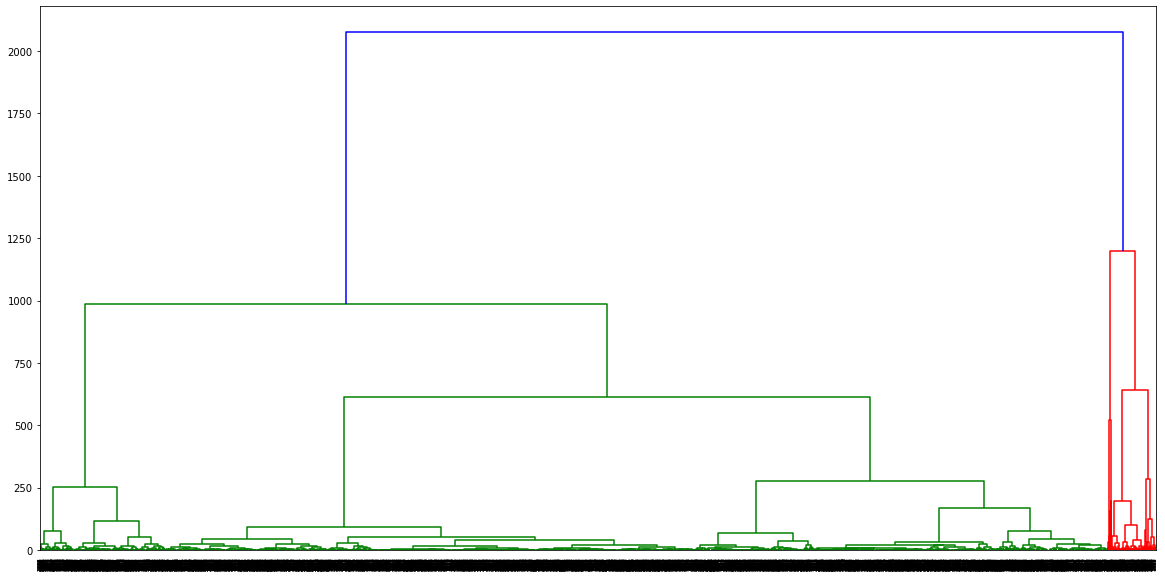

In [79]:
pca_components = pca.fit_transform(X_hd)
agg_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

plt.figure(figsize=(20,10))
dendrogram(lnkg(pca_components, method='ward'))
plt.show()

## Agglomerative Clustering for All Features with UMAP Components

UMAP fares much more poorly compared to PCA with a silhouette score down to 0.56 from 0.77.

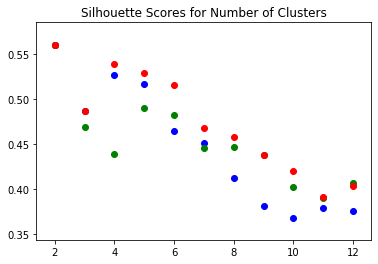

Best Silhouette score with ward linkage is 0.560408890247345 with 2 clusters. 
Best Silhouette score with complete linkage is 0.560408890247345 with 2 clusters. 
Best Silhouette score with average linkage is 0.560408890247345 with 2 clusters. 
Best Davies Bouldin score:  0.6250267832763131


In [398]:
agglomerative_clustering(X_all, 'UMAP', neighbors=10, min_distance=0.1)

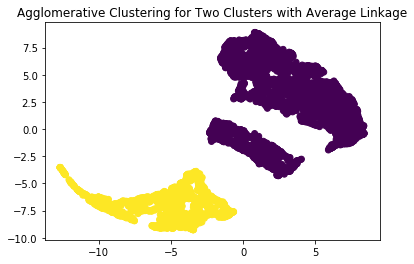

Silhouette Score:  0.5912625
Davies Bouldin Index:  0.5442469179259961


In [535]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)


agg_clusters = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
cluster_labels = agg_clusters.fit_predict(umap_results)

plt.title('Agglomerative Clustering for Two Clusters with Average Linkage')
plt.scatter(umap_results[:,0], umap_results[:,1], c=cluster_labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(umap_results, cluster_labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(umap_results, cluster_labels))

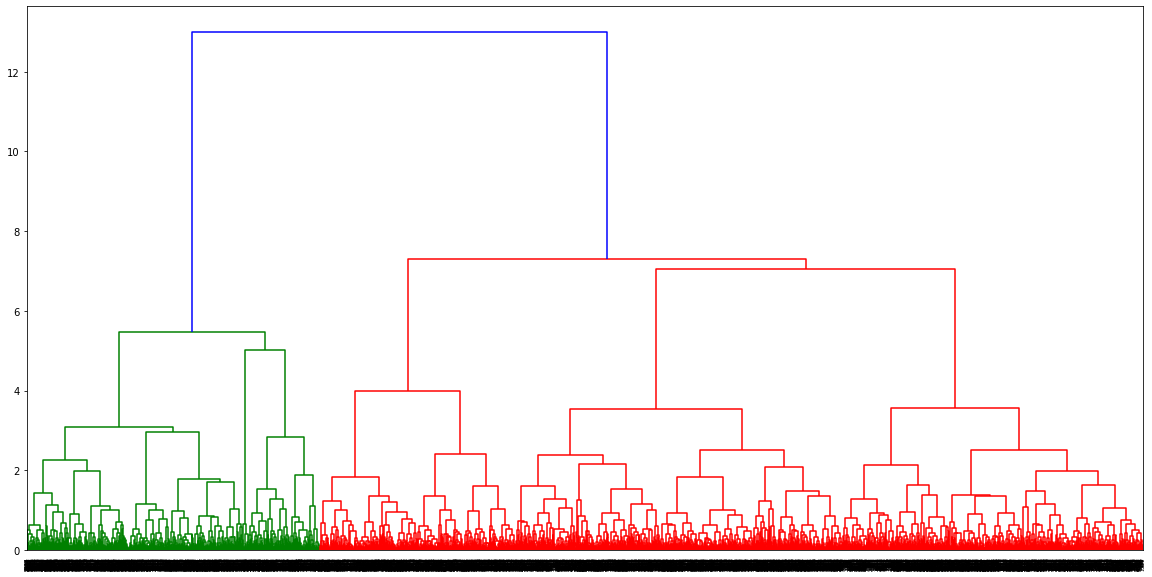

In [536]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)
agg_cluster = AgglomerativeClustering(linkage='average', affinity='euclidean', n_clusters=2)
clusters = agg_cluster.fit_predict(umap_results)

plt.figure(figsize=(20,10))
dendrogram(lnkg(umap_results, method='average'))
plt.show()

## Agglomerative Clustering for Features Highly Correlated with humansDeaths with UMAP Components

Similar to K-means clustering, this is the poorest performer by far with a silhouette score of 0.46 and DB index of 0.68. However, the clusters at least appear to be completely separated, unlike the K-means method. I'll show the complete linkage with three clusters as well as this is the first time I've seen three clusters out-perform two.

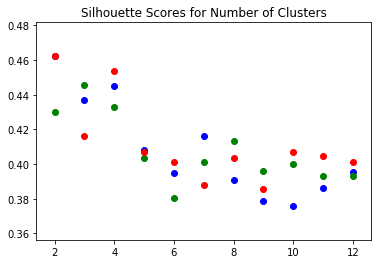

Best Silhouette score with ward linkage is 0.4622753858566284 with 2 clusters. 
Best Silhouette score with complete linkage is 0.4456113576889038 with 3 clusters. 
Best Silhouette score with average linkage is 0.4622753858566284 with 2 clusters. 
Best Davies Bouldin score:  0.6802449498976527


In [399]:
agglomerative_clustering(X_hd, 'UMAP', neighbors=30, min_distance=0.25)

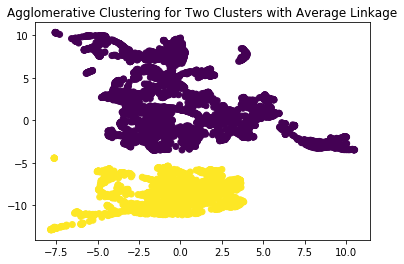

Silhouette Score:  0.4996776
Davies Bouldin Index:  0.6976677924897093


In [405]:
umap_results = umap.UMAP(n_neighbors=30,
                      min_dist=0.25,
                      metric='correlation').fit_transform(X_hd)


agg_clusters = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
cluster_labels = agg_clusters.fit_predict(umap_results)

plt.title('Agglomerative Clustering for Two Clusters with Average Linkage')
plt.scatter(umap_results[:,0], umap_results[:,1], c=cluster_labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(umap_results, cluster_labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(umap_results, cluster_labels))

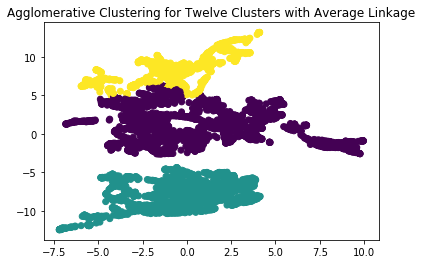

Silhouette Score:  0.4371869
Davies Bouldin Index:  0.8574155813254362


In [406]:
umap_results = umap.UMAP(n_neighbors=30,
                      min_dist=0.25,
                      metric='correlation').fit_transform(X_hd)

agg_clusters = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=3)
cluster_labels = agg_clusters.fit_predict(umap_results)

plt.title('Agglomerative Clustering for Twelve Clusters with Average Linkage')
plt.scatter(umap_results[:,0], umap_results[:,1], c=cluster_labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(umap_results, cluster_labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(umap_results, cluster_labels))

## Cluster Labels for humansDeaths features with PCA Components

In [80]:
# Agglomerative Clustering with humansDeaths features

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
labels = agg_cluster.fit_predict(umap_results)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_hd_agg_clusters'] = labels
group_0 = X[X['X_hd_agg_clusters'] == 0]
group_1 = X[X['X_hd_agg_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 291)
5831
{0: 2528, 1: 3303}
norm_sumDeaths : [0.]
norm_sumDestroyed : [0.]
norm_sumDestroyed_std : [0.]
X_all_umap_kmeans_clusters : [0.]
X_hd_agg_clusters : [0.]
norm_sumSlaughtered : [1.4662974e-230]
norm_sumSlaughtered_std : [1.4662974e-230]
norm_sumCases : [2.66375724e-188]
norm_sumCases_std : [2.66375724e-188]
Europe : [1.73791272e-174]
Asia : [1.45243718e-164]
mammals : [1.94689626e-135]
OIE : [1.69748176e-130]
National authorities : [1.72204066e-109]
wild : [5.32961805e-81]
Influenza - Avian : [2.02050609e-78]
X_hd_pca_kmeans_clusters : [1.80453219e-75]
African swine fever : [5.83985447e-73]
MERS-CoV  : [2.74422204e-72]
Saudi Arabia : [8.04423814e-66]
humansAge : [5.47057404e-59]
H5N1 HPAI : [2.44116209e-55]
birds : [8.64292912e-55]
norm_sumAtRisk_std : [5.45593288e-52]
norm_sumAtRisk : [5.45593288e-52]
Centroid Admin1 : [4.83178292e-50]
UnknownSerotypes : [1.45296548e-47]
Centroid Admin2 : [5.64700765e-41]
norm_humansAge : [1.61672559e-37]
norm_humansAge_std : [1.616725

In [81]:
def plot_hd_agglomerative_clusters():
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['sumCases'])
    plt.title('Agglomerative Clusters vs sumCases (p-value = 3.630e-24)')
    box.set_ylim(0, 100000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['sumDeaths'])
    plt.title('Agglomerative Clusters vs sumDeaths (p-value = 3.834e-23)')
    box.set_ylim(0, 50000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['humansAffected'])
    plt.title('Agglomerative Clusters vs humansAffected (p-value = 1.26e-106)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['humansDeaths'])
    plt.title('Agglomerative Clusters vs humansDeaths (p-value = 6.24e-114)')
    box.set_ylim(0, 100)
    plt.show()
    
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Africa'])
    plt.title('Agglomerative Clusters vs Africa (p-value = 4.27e-224)')
    plt.show()

    plt.figure(figsize=(10,3))
    sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Americas'])
    plt.title('Agglomerative Clusters vs Americas (p-value = 0.683)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Asia'])
    plt.title('Agglomerative Clusters vs Asia (p-value = 1.452e-164)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Europe'])
    plt.title('Agglomerative Clusters vs Europe (p-value = 1.737e-174)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['African swine fever'])
    plt.title('Agglomerative Clusters vs African swine fever (p-value = 5.839e-73)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Foot and mouth disease'])
    plt.title('Agglomerative Clusters vs Foot and mouth disease (p-value = 0.059)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Influenza - Avian'])
    plt.title('Agglomerative Clusters vs Influenza - Avian (p-value = 2.020e-78)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['UnknownSerotypes'])
    plt.title('Agglomerative Clusters vs UnknownSerotypes (p-value = 1.452e-47)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['birds'])
    plt.title('Agglomerative Clusters vs birds (p-value = 8.642e-55)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['mammals'])
    plt.title('Agglomerative Clusters vs mammals (p-value = 1.946e-135)')
    plt.show()


    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['wild'])
    plt.title('Agglomerative Clusters vs wild (p-value = 5.329e-181)')
    plt.show()

## Agglomerative Clusters (humansDeaths Features, PCA components)

This model mirrors the K-Means cluster using all features with UMAP components very strongly - it clusters outbreaks affecting humans with the African Swine Fever and wild animals, and aggregates outbreaks high in animal deaths and cases with Asia and the Avian influenza. It's beginning to look like we may be able to predict whether an animal disease outbreak will have severe consequences on humans or animals.


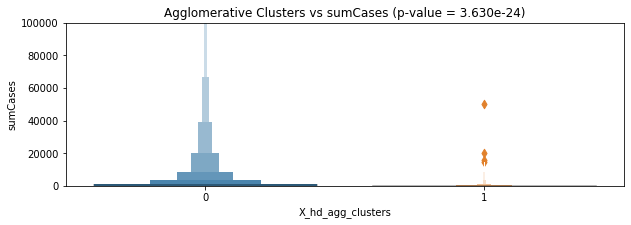

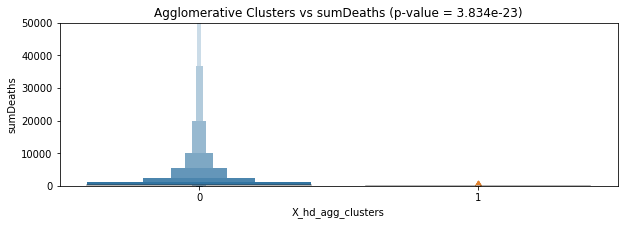

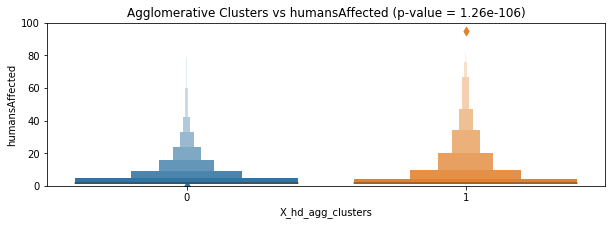

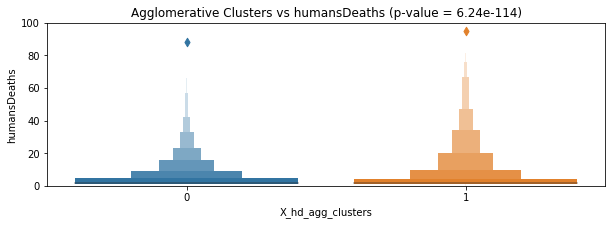

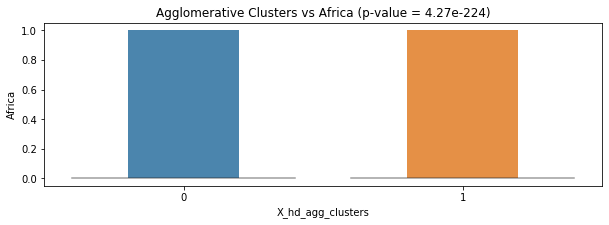

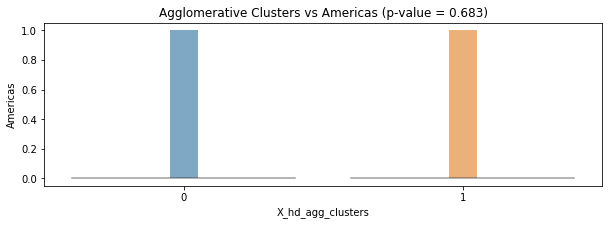

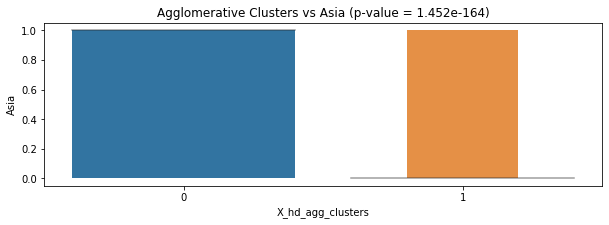

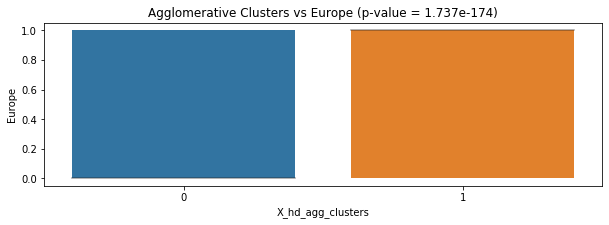

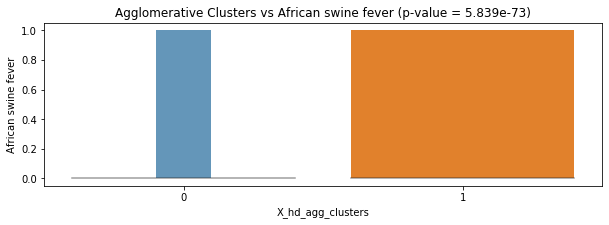

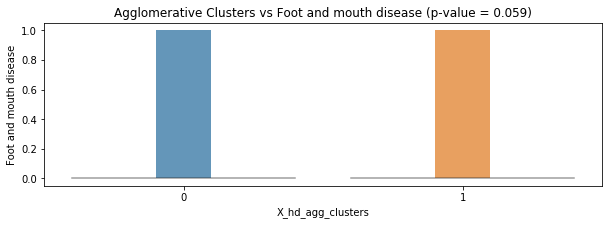

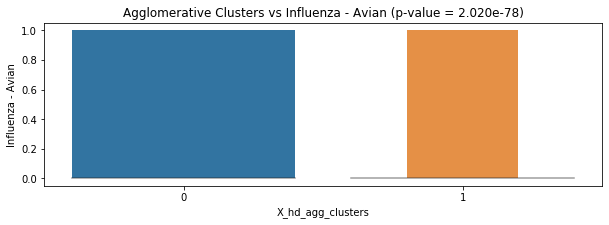

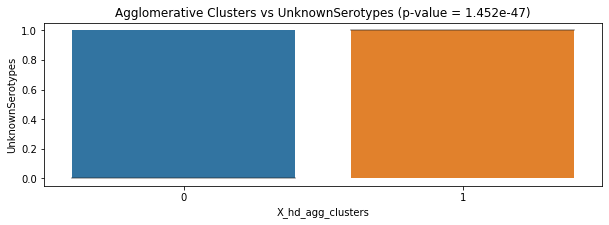

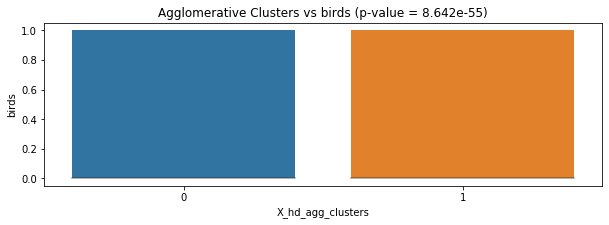

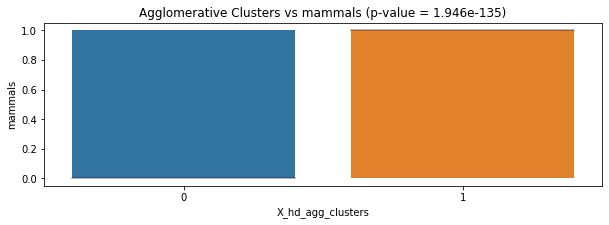

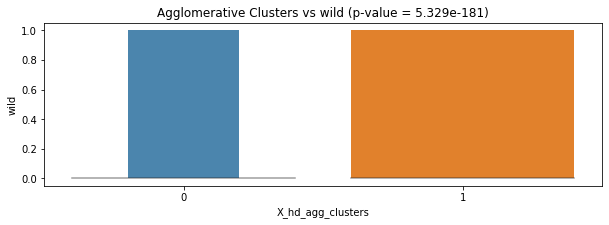

In [82]:
plot_hd_agglomerative_clusters()


## DBSCAN with PCA Components 

In [83]:
def dbscan_find_clusters(eps, min_samples, X):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    num_labels = len(set(labels))
    num_samples = X.shape[0]
    silhouettes_dbscan = {}
    if num_labels == 1 or num_labels == num_samples:
          silhouette = -1
          silhouettes_dbscan[silhouette] = min_samples
          print('{} min samples and {} eps have no clusters.'.format(min_samples, eps))
    else:
          silhouette = metrics.silhouette_score(X, labels)
          print('{} min samples and {} eps have {} silhouette score with {} clusters.'.format(min_samples, eps, silhouette, num_labels))
          return {
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': silhouette,
            'davies_bouldin': metrics.davies_bouldin_score(X, labels)
            }
          silhouettes_dbscan[silhouette] = min_samples
    plt.title('Silhouette Scores for {} eps'.format(eps))
    plt.scatter(list(silhouettes_dbscan.values()), list(silhouettes_dbscan.keys()), color='blue')
    plt.xlabel('Min Samples')
    plt.ylabel('Silhouette Score')

## DBSCAN with All Features with PCA Components

This model fairs poorly - the highest silhouette score is 0.49.

In [85]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)

results = [dbscan_find_clusters(eps, min_samples, pca_components) for eps in [0.5, 1, 2] for min_samples in [5,10,15,20]]


5 min samples and 0.5 eps have -0.3682641465227867 silhouette score with 102 clusters.
10 min samples and 0.5 eps have -0.3209613995268464 silhouette score with 46 clusters.
15 min samples and 0.5 eps have -0.3182287728326098 silhouette score with 43 clusters.
20 min samples and 0.5 eps have -0.40666611892950133 silhouette score with 33 clusters.
5 min samples and 1 eps have -0.30669825660198397 silhouette score with 37 clusters.
10 min samples and 1 eps have -0.3252792453132309 silhouette score with 20 clusters.
15 min samples and 1 eps have -0.13771033608566385 silhouette score with 12 clusters.
20 min samples and 1 eps have -0.20351386621603726 silhouette score with 11 clusters.
5 min samples and 2 eps have 0.49814581693483445 silhouette score with 11 clusters.
10 min samples and 2 eps have 0.3374144200363406 silhouette score with 6 clusters.
15 min samples and 2 eps have 0.2902823499463303 silhouette score with 7 clusters.
20 min samples and 2 eps have 0.22091885157383528 silhouett

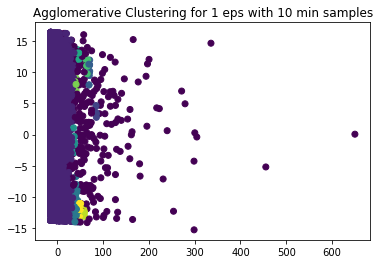

Silhouette Score:  0.4981458169348344
Davies Bouldin Index:  2.1119837449684495


In [93]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)

dbscan = DBSCAN(eps=2, min_samples=5)
labels = dbscan.fit_predict(pca_components)

plt.title('Agglomerative Clustering for 1 eps with 10 min samples')
plt.scatter(pca_components[:,0], pca_components[:,1], c=labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(pca_components, labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, labels))

## DBSCAN with PCA Components humansDeaths

At first glance, it appears this model fairs better with high silhouette scores, but it has broken the data into too many clusters.

In [425]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

results = [dbscan_find_clusters(eps, min_samples, pca_components) for eps in [0.5,1,2] for min_samples in [5,10,15]]


5 min samples and 0.5 eps have -0.05439051864535696 silhouette score with 32 clusters.
10 min samples and 0.5 eps have -0.10905880961983203 silhouette score with 19 clusters.
15 min samples and 0.5 eps have 0.15871074772214921 silhouette score with 17 clusters.
5 min samples and 1 eps have -0.07156421583282196 silhouette score with 15 clusters.
10 min samples and 1 eps have 0.048828392727522256 silhouette score with 10 clusters.
15 min samples and 1 eps have 0.43422966446924055 silhouette score with 8 clusters.
5 min samples and 2 eps have 0.6738493280822249 silhouette score with 7 clusters.
10 min samples and 2 eps have 0.7150805686387631 silhouette score with 6 clusters.
15 min samples and 2 eps have 0.6614172975866344 silhouette score with 6 clusters.


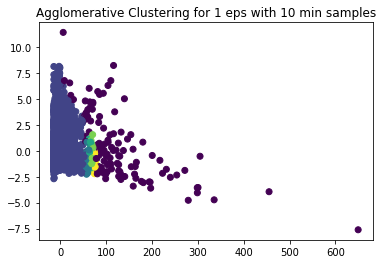

Silhouette Score:  0.715080568639317
Davies Bouldin Index:  0.9973056758363832


In [540]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

dbscan = DBSCAN(eps=2, min_samples=10)
labels = dbscan.fit_predict(pca_components)

plt.title('Agglomerative Clustering for 1 eps with 10 min samples')
plt.scatter(pca_components[:,0], pca_components[:,1], c=labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(pca_components, labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, labels))

## DBSCAN with UMAP Components 

In all honesty, I'm not sure what's going on here - I am unable to replicate the silhouette scores found in the function. 

In [86]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)

results = [dbscan_find_clusters(eps, min_samples, umap_results) for eps in [0.5,1,2] for min_samples in [5,10,15,20]]

5 min samples and 0.5 eps have 0.5420340895652771 silhouette score with 3 clusters.
10 min samples and 0.5 eps have 0.5420340895652771 silhouette score with 3 clusters.
15 min samples and 0.5 eps have 0.17844121158123016 silhouette score with 6 clusters.
20 min samples and 0.5 eps have 0.13058412075042725 silhouette score with 6 clusters.
5 min samples and 1 eps have 0.5971481204032898 silhouette score with 2 clusters.
10 min samples and 1 eps have 0.5971481204032898 silhouette score with 2 clusters.
15 min samples and 1 eps have 0.5971481204032898 silhouette score with 2 clusters.
20 min samples and 1 eps have 0.5971481204032898 silhouette score with 2 clusters.
5 min samples and 2 eps have 0.5971481204032898 silhouette score with 2 clusters.
10 min samples and 2 eps have 0.5971481204032898 silhouette score with 2 clusters.
15 min samples and 2 eps have 0.5971481204032898 silhouette score with 2 clusters.
20 min samples and 2 eps have 0.5971481204032898 silhouette score with 2 cluster

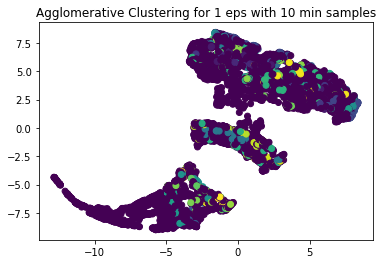

Silhouette Score:  -0.67867434
Davies Bouldin Index:  44.31702252060582
Cluster labels: [-1  0  1] [   6 2039 3786]


In [92]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)

dbscan = DBSCAN(eps=1, min_samples=10)
labels = dbscan.fit_predict(X_hd)

plt.title('Agglomerative Clustering for 1 eps with 10 min samples')
plt.scatter(umap_results[:,0], umap_results[:,1], c=labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(umap_results, labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(umap_results, labels))
print('Cluster labels:', unique, counts)

## DBSCAN with UMAP Components humansDeaths

The lowest silhouette score seen so far at 0.31.

In [89]:
umap_results = umap.UMAP(n_neighbors=30,
                      min_dist=0.25,
                      metric='correlation').fit_transform(X_hd)
results = [dbscan_find_clusters(eps, min_samples, umap_results) for eps in [0.5,1,2] for min_samples in [5,10,15,20]]


5 min samples and 0.5 eps have -0.030591733753681183 silhouette score with 11 clusters.
10 min samples and 0.5 eps have 0.06048307195305824 silhouette score with 11 clusters.
15 min samples and 0.5 eps have 0.04400286078453064 silhouette score with 13 clusters.
20 min samples and 0.5 eps have 0.24317890405654907 silhouette score with 16 clusters.
5 min samples and 1 eps have 0.22584456205368042 silhouette score with 5 clusters.
10 min samples and 1 eps have 0.22584456205368042 silhouette score with 5 clusters.
15 min samples and 1 eps have 0.22584456205368042 silhouette score with 5 clusters.
20 min samples and 1 eps have 0.22584456205368042 silhouette score with 5 clusters.
5 min samples and 2 eps have 0.3159792721271515 silhouette score with 3 clusters.
10 min samples and 2 eps have 0.3159792721271515 silhouette score with 3 clusters.
15 min samples and 2 eps have 0.3159792721271515 silhouette score with 3 clusters.
20 min samples and 2 eps have 0.3159792721271515 silhouette score wi

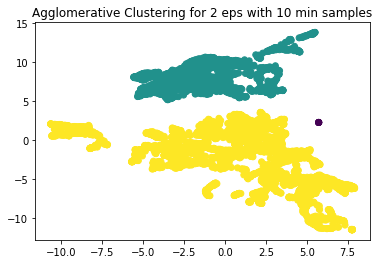

Silhouette Score:  0.25402886
Davies Bouldin Index:  0.7237930272335821
Cluster labels: [-1  0  1] [   6 2039 3786]


In [90]:
umap_results = umap.UMAP(n_neighbors=30,
                      min_dist=0.25,
                      metric='correlation').fit_transform(X_hd)

dbscan = DBSCAN(eps=2, min_samples=10)
labels = dbscan.fit_predict(umap_results)
unique, counts = np.unique(labels, return_counts=True)

plt.title('Agglomerative Clustering for 2 eps with 10 min samples')
plt.scatter(umap_results[:,0], umap_results[:,1], c=labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(umap_results, labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(umap_results, labels))
print('Cluster labels:', unique, counts)

In [81]:
def plot_hd_dbscan_clusters():
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['sumCases'])
    plt.title('Agglomerative Clusters vs sumCases (p-value = 3.630e-24)')
    box.set_ylim(0, 100000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['sumDeaths'])
    plt.title('Agglomerative Clusters vs sumDeaths (p-value = 3.834e-23)')
    box.set_ylim(0, 50000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['humansAffected'])
    plt.title('Agglomerative Clusters vs humansAffected (p-value = 1.26e-106)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['humansDeaths'])
    plt.title('Agglomerative Clusters vs humansDeaths (p-value = 6.24e-114)')
    box.set_ylim(0, 100)
    plt.show()
    
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Africa'])
    plt.title('Agglomerative Clusters vs Africa (p-value = 4.27e-224)')
    plt.show()

    plt.figure(figsize=(10,3))
    sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Americas'])
    plt.title('Agglomerative Clusters vs Americas (p-value = 0.683)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Asia'])
    plt.title('Agglomerative Clusters vs Asia (p-value = 1.452e-164)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Europe'])
    plt.title('Agglomerative Clusters vs Europe (p-value = 1.737e-174)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['African swine fever'])
    plt.title('Agglomerative Clusters vs African swine fever (p-value = 5.839e-73)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Foot and mouth disease'])
    plt.title('Agglomerative Clusters vs Foot and mouth disease (p-value = 0.059)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['Influenza - Avian'])
    plt.title('Agglomerative Clusters vs Influenza - Avian (p-value = 2.020e-78)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['UnknownSerotypes'])
    plt.title('Agglomerative Clusters vs UnknownSerotypes (p-value = 1.452e-47)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['birds'])
    plt.title('Agglomerative Clusters vs birds (p-value = 8.642e-55)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['mammals'])
    plt.title('Agglomerative Clusters vs mammals (p-value = 1.946e-135)')
    plt.show()


    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_hd_agg_clusters'], y=X['wild'])
    plt.title('Agglomerative Clusters vs wild (p-value = 5.329e-181)')
    plt.show()

## GMM With PCA Components

In [94]:
 def gmm_find_clusters(n_components, covariance_type, X):
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    labels = gmm.fit_predict(X)
    num_labels = len(set(labels))
    num_samples = X.shape[0]
    silhouettes_gmm = {}
    if num_labels == 1 or num_labels == num_samples:
        silhouette = -1
        silhouettes_dbscan[silhouette] = min_samples
        print('{} n components and {} covariance have no clusters.'.format(n_components, covariance_type))
    else:
          silhouette = metrics.silhouette_score(X, labels)
          print('{} n components and {} covariance have {} silhouette score with {} clusters.'.format(n_components, covariance_type, silhouette, num_labels))
          return {
            'n_components': n_components,
            'covariance_type': covariance_type,
            'silhouette_score': silhouette,
            'davies_bouldin': metrics.davies_bouldin_score(X, labels)
            }
          silhouettes_dbscan[silhouette] = n_components
    plt.title('Silhouette Scores for {} covariance'.format(covariance_type))
    plt.scatter(list(silhouettes_gmm.values()), list(silhouettes_gmm.keys()), color='blue')
    plt.xlabel('Number of Components')
    plt.ylabel('Silhouette Score')
    plt.show()

## GMM Clustering with All Features with PCA Components

This model produces similar results to K-means and Agglomerative clustering with a high silhouette score of 0.71 at two clusters. While tied covariance actually produces a higher silhouette score of 0.86, the data is clustered extremely unevenly.

In [438]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)

results = [gmm_find_clusters(n_components,covariance_type, pca_components) for n_components in [2,5,10,15]
           for covariance_type in ['full','tied','diag','spherical']]

2 n components and full covariance have 0.6674649567290156 silhouette score with 2 clusters.
2 n components and tied covariance have 0.8603324095978963 silhouette score with 2 clusters.
2 n components and diag covariance have 0.6686573596571233 silhouette score with 2 clusters.
2 n components and spherical covariance have 0.7161363881538289 silhouette score with 2 clusters.
5 n components and full covariance have 0.1901991687636544 silhouette score with 5 clusters.
5 n components and tied covariance have 0.6806127158102079 silhouette score with 4 clusters.
5 n components and diag covariance have 0.32434257241099723 silhouette score with 5 clusters.
5 n components and spherical covariance have 0.4750788936773683 silhouette score with 5 clusters.
10 n components and full covariance have 0.19661061940133845 silhouette score with 10 clusters.
10 n components and tied covariance have 0.3818628805978084 silhouette score with 10 clusters.
10 n components and diag covariance have 0.38712092682

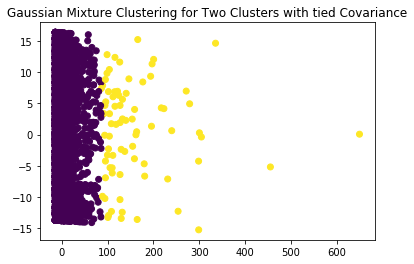

Silhouette Score:  0.8603438523920628
Davies Bouldin Index:  0.4695740078946218


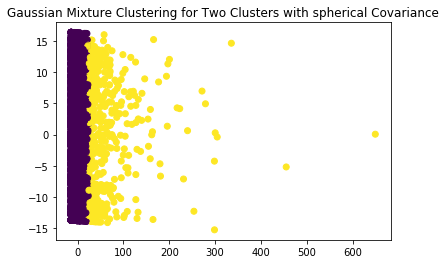

Silhouette Score:  0.7161465830799263
Davies Bouldin Index:  0.709257452983156


In [97]:
# plotting the clusters with the best silhouette score

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)

for c_type in ['tied', 'spherical']:
    gmm = GaussianMixture(n_components=2, covariance_type=c_type)
    cluster_labels = gmm.fit_predict(pca_components)

    plt.title('Gaussian Mixture Clustering for Two Clusters with {} Covariance'.format(c_type))
    plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
    plt.show()

    print('Silhouette Score: ', metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean'))
    print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, cluster_labels))

## GMM Clustering with humansDeaths PCA Components

Both tied and spherical covariance types cluster the data unevenly for their high silhouette scores of 0.88 and 0.68, respectively. Tied gives a lower DB index, so I may use that for labeling.

In [442]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

results = [gmm_find_clusters(n_components,covariance_type, pca_components) for n_components in [2,5,10,15]
           for covariance_type in ['full','tied','diag','spherical']]

2 n components and full covariance have 0.5326343311385986 silhouette score with 2 clusters.
2 n components and tied covariance have 0.8887560509300614 silhouette score with 2 clusters.
2 n components and diag covariance have 0.5522201061447705 silhouette score with 2 clusters.
2 n components and spherical covariance have 0.6851218333718575 silhouette score with 2 clusters.
3 n components and full covariance have 0.3797889479300346 silhouette score with 3 clusters.
3 n components and tied covariance have 0.808734402574715 silhouette score with 3 clusters.
3 n components and diag covariance have 0.40231578641355475 silhouette score with 3 clusters.
3 n components and spherical covariance have 0.5581147777140304 silhouette score with 3 clusters.
4 n components and full covariance have 0.3525013715947205 silhouette score with 4 clusters.
4 n components and tied covariance have 0.7583730106598935 silhouette score with 4 clusters.
4 n components and diag covariance have 0.3865852656183438 s

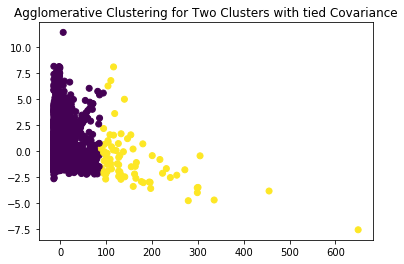

Silhouette Score:  0.8887577210065515
Davies Bouldin Index:  0.44708902982524795


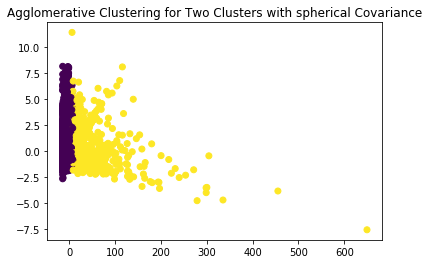

Silhouette Score:  0.6854103818486932
Davies Bouldin Index:  0.7342114023489162


In [98]:
# plotting the clusters with the best silhouette score

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

for c_type in ['tied','spherical']:
    gmm = GaussianMixture(n_components=2, covariance_type=c_type)
    cluster_labels = gmm.fit_predict(pca_components)

    plt.title('Agglomerative Clustering for Two Clusters with {} Covariance'.format(c_type))
    plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
    plt.show()

    print('Silhouette Score: ', metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean'))
    print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, cluster_labels))

## GMM Clustering for All Features with UMAP Components

Any covariance produces a fair silhouette score of 0.61 with two clusters.

In [445]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)

results = [gmm_find_clusters(n_components,covariance_type, umap_results) for n_components in [2,5,10,15]
           for covariance_type in ['full','tied','diag','spherical']]

2 n components and full covariance have 0.6141465306282043 silhouette score with 2 clusters.
2 n components and tied covariance have 0.6150309443473816 silhouette score with 2 clusters.
2 n components and diag covariance have 0.6138144135475159 silhouette score with 2 clusters.
2 n components and spherical covariance have 0.6139499545097351 silhouette score with 2 clusters.
5 n components and full covariance have 0.5533324480056763 silhouette score with 5 clusters.
5 n components and tied covariance have 0.5208461880683899 silhouette score with 5 clusters.
5 n components and diag covariance have 0.5590235590934753 silhouette score with 5 clusters.
5 n components and spherical covariance have 0.5291510224342346 silhouette score with 5 clusters.
10 n components and full covariance have 0.42931947112083435 silhouette score with 10 clusters.
10 n components and tied covariance have 0.4342024624347687 silhouette score with 10 clusters.
10 n components and diag covariance have 0.448788911104

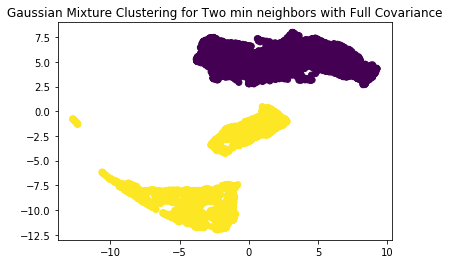

Silhouette Score:  0.57917416
Davies Bouldin Index:  0.6402765181514637


In [446]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)

gmm = GaussianMixture(n_components=2, covariance_type='diag')
cluster_labels = gmm.fit_predict(umap_results)

plt.title('Gaussian Mixture Clustering for Two min neighbors with Full Covariance')
plt.scatter(umap_results[:,0], umap_results[:,1], c=cluster_labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(umap_results, cluster_labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(umap_results, cluster_labels))

## GMM Clustering for humansDeaths Features with UMAP Components

As with all other models, the features highly correlated with humansDeaths with UMAP components provide the worst clustering metrics.

In [447]:
umap_results = umap.UMAP(n_neighbors=30,
                      min_dist=0.25,
                      metric='correlation').fit_transform(X_hd)

results = [gmm_find_clusters(n_components,covariance_type, umap_results) for n_components in [2,5,10,15]
           for covariance_type in ['full','tied','diag','spherical']]

2 n components and full covariance have 0.40577661991119385 silhouette score with 2 clusters.
2 n components and tied covariance have 0.41997474431991577 silhouette score with 2 clusters.
2 n components and diag covariance have 0.37413862347602844 silhouette score with 2 clusters.
2 n components and spherical covariance have 0.4309743046760559 silhouette score with 2 clusters.
5 n components and full covariance have 0.4366190731525421 silhouette score with 5 clusters.
5 n components and tied covariance have 0.4462679624557495 silhouette score with 5 clusters.
5 n components and diag covariance have 0.42243245244026184 silhouette score with 5 clusters.
5 n components and spherical covariance have 0.473453164100647 silhouette score with 5 clusters.
10 n components and full covariance have 0.3671221435070038 silhouette score with 10 clusters.
10 n components and tied covariance have 0.3893263638019562 silhouette score with 10 clusters.
10 n components and diag covariance have 0.3906381130

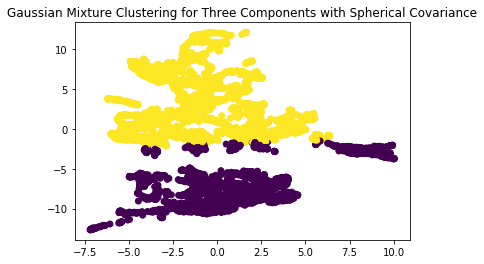

Silhouette Score:  0.47733784
Davies Bouldin Index:  0.7750543340441007


In [552]:
umap_results = umap.UMAP(n_neighbors=30,
                      min_dist=0.25,
                      metric='correlation').fit_transform(X_hd)

gmm = GaussianMixture(n_components=2, covariance_type='spherical')
cluster_labels = gmm.fit_predict(umap_results)

plt.title('Gaussian Mixture Clustering for Three Components with Spherical Covariance')
plt.scatter(umap_results[:,0], umap_results[:,1], c=cluster_labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(umap_results, cluster_labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(umap_results, cluster_labels))

In [99]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
gmm = GaussianMixture(n_components=2, covariance_type='spherical')
labels = gmm.fit_predict(pca_components)


print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_all_pca_gmm_clusters'] = labels
group_0 = X[X['X_all_pca_gmm_clusters'] == 0]
group_1 = X[X['X_all_pca_gmm_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 292)
5831
{0: 5356, 1: 475}
norm_sumCases : [0.]
norm_sumDeaths : [0.]
norm_sumCases_std : [0.]
X_hd_pca_kmeans_clusters : [0.]
X_all_pca_gmm_clusters : [0.]
norm_sumAtRisk_std : [2.34275894e-180]
norm_sumAtRisk : [2.34275894e-180]
X_all_umap_kmeans_clusters : [3.16289361e-178]
X_hd_agg_clusters : [4.00541063e-158]
sumDeaths : [2.84251581e-134]
norm_sumDestroyed : [3.3377093e-121]
norm_sumDestroyed_std : [3.3377093e-121]
Influenza - Avian : [2.23915122e-116]
birds : [8.89762016e-112]
mammals : [6.77767611e-103]
sumCases : [6.6008471e-93]
sumAtRisk : [2.86419541e-82]
sumDestroyed : [6.94765877e-57]
UnknownSerotypes : [5.45855087e-55]
H5N2 HPAI : [8.07960308e-55]
Taiwan (Province of China) : [1.77306836e-53]
unspecified : [4.23603536e-49]
Asia : [1.2083521e-47]
Iraq : [4.43455453e-47]
H5N1 HPAI : [1.84588212e-44]
Europe : [6.42634761e-38]
H7N9 LPAI : [7.47039828e-37]
norm_humansDeaths : [8.34132889e-30]
norm_humansDeaths_std : [8.34132889e-30]
norm_humansAffected_std : [1.09052589

In [100]:
def plot_gmm_all_clusters():
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['sumCases'])
    plt.title('Gaussian Mixture Clusters vs sumCases (p-value = 6.600e-93)')
    box.set_ylim(0, 100000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['sumDeaths'])
    plt.title('Gaussian Mixture Clusters vs sumDeaths (p-value = 2.842e-134)')
    box.set_ylim(0, 50000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['humansAffected'])
    plt.title('Gaussian Mixture Clusters vs humansAffected (p-value = 1.130e-14)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['humansDeaths'])
    plt.title('Gaussian Mixture Clusters vs humansDeaths (p-value = 1.061e-16)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['Americas'])
    plt.title('Gaussian Mixture Clusters vs Americas (p-value = 0.945)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['Africa'])
    plt.title('Gaussian Mixture Clusters vs Africa (p-value = 0.283)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['Asia'])
    plt.title('Gaussian Mixture Clusters vs Asia (p-value = 1.208e-47)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['Europe'])
    plt.title('Gaussian Mixture Clusters vs Europe (p-value = 6.426e-38)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['African swine fever'])
    plt.title('Gaussian Mixture Clusters vs African swine fever (p-value = 6.717e-21)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['Foot and mouth disease'])
    plt.title('Gaussian Mixture Clusters vs Foot and mouth disease (p-value = 4.872e-12)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['Influenza - Avian'])
    plt.title('Gaussian Mixture Clusters vs Influenza - Avian (p-value = 2.239e-116)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['UnknownSerotypes'])
    plt.title('Gaussian Mixture Clusters vs UnknownSerotypes (p-value = 5.458e-55)')
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['birds'])
    plt.title('Gaussian Mixture Clusters vs birds (p-value = 8.897e-112)')
    plt.show()
    
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['mammals'])
    plt.title('Gaussian Mixture Clusters vs mammals (p-value = 6.777e-103)')
    plt.show()


    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_pca_gmm_clusters'], y=X['wild'])
    plt.title('Gaussian Mixture Clusters vs wild (p-value = 1.474e-15)')
    plt.show()

## Gmm Clusters (all Features, PCA components)

Similar to the first K-means clustering, this model clusters datapoints high in both animal and human cases and deaths. This would be very interesting, except that it is not clear what causes this as all of the other variables are more significant in the other clusters.


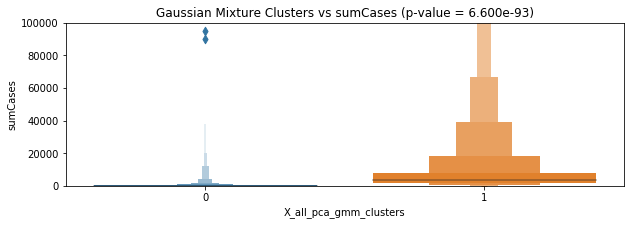

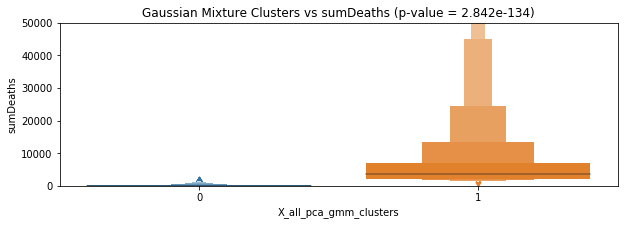

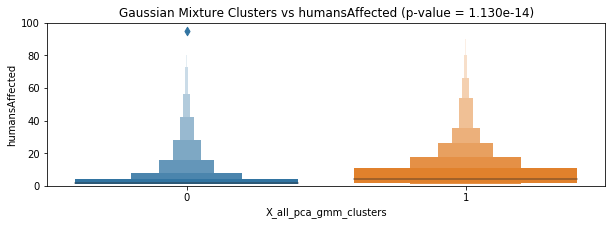

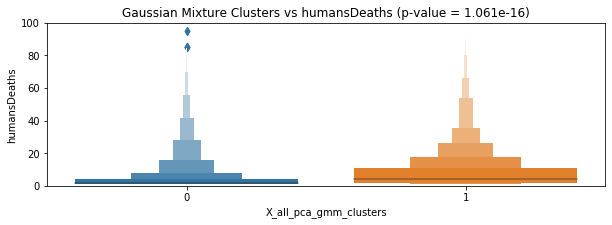

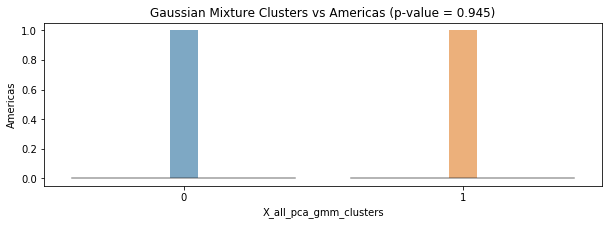

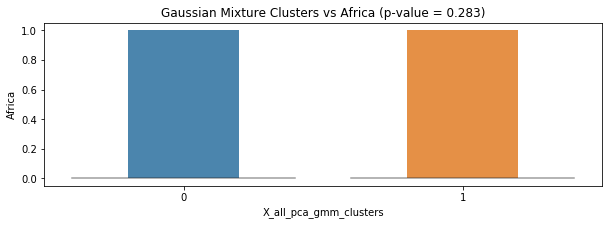

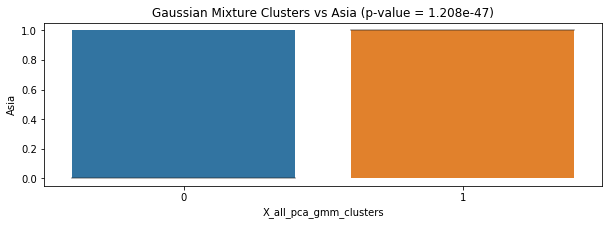

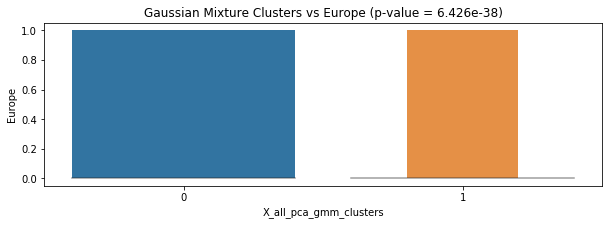

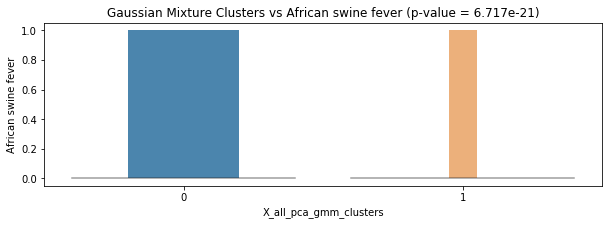

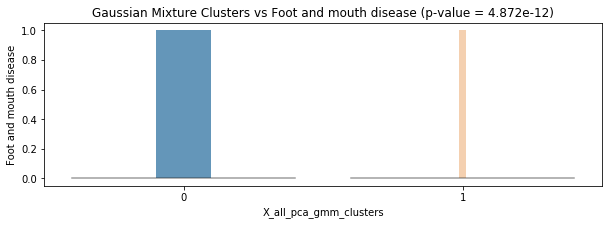

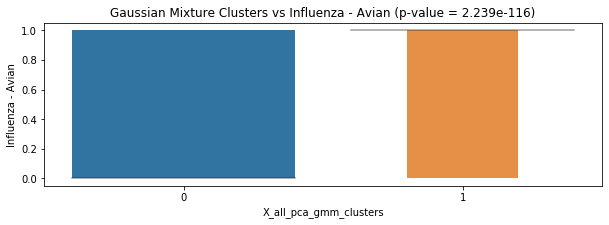

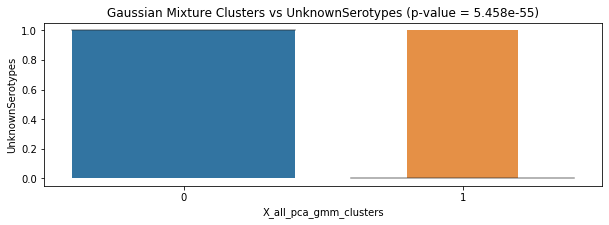

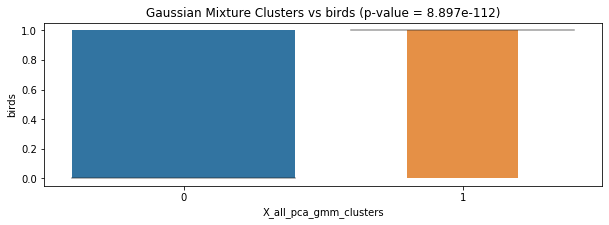

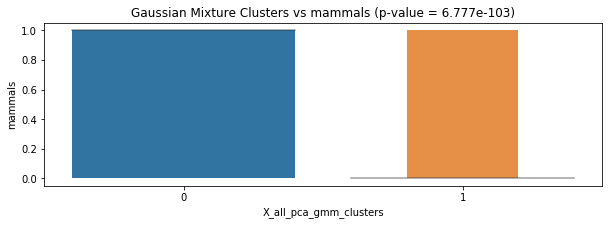

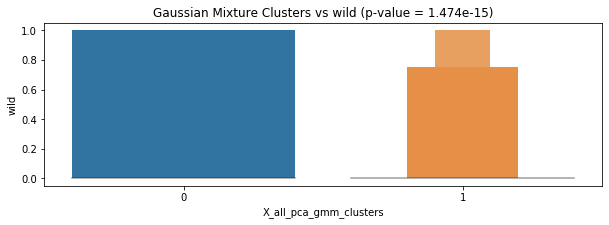

In [101]:
plot_gmm_all_clusters()

In [104]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_all)

gmm = GaussianMixture(n_components=2, covariance_type='spherical')
labels = gmm.fit_predict(umap_results)

print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_all_umap_gmm_clusters'] = labels
group_0 = X[X['X_all_umap_gmm_clusters'] == 0]
group_1 = X[X['X_all_umap_gmm_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 294)
5831
{0: 3435, 1: 2396}
norm_sumDeaths : [0.]
norm_sumDestroyed : [0.]
norm_sumDestroyed_std : [0.]
X_all_umap_kmeans_clusters : [0.]
X_hd_agg_clusters : [0.]
X_all_umap_gmm_clusters : [0.]
norm_sumSlaughtered : [5.01465345e-223]
norm_sumSlaughtered_std : [5.01465345e-223]
norm_sumCases : [4.21450982e-199]
norm_sumCases_std : [4.21450982e-199]
X_all_pca_gmm_clusters : [2.21264737e-174]
Europe : [6.87249829e-164]
Asia : [3.92799582e-160]
mammals : [6.57056166e-133]
OIE : [1.15021317e-132]
National authorities : [1.58106319e-114]
X_hd_pca_kmeans_clusters : [7.35565958e-83]
wild : [2.37080842e-76]
MERS-CoV  : [5.18305836e-76]
Influenza - Avian : [6.70217746e-75]
Saudi Arabia : [2.52562582e-71]
African swine fever : [4.58327487e-69]
humansAge : [1.01548804e-62]
norm_sumAtRisk_std : [3.52987115e-60]
norm_sumAtRisk : [3.52987115e-60]
Centroid Admin1 : [4.9387741e-54]
birds : [7.6727e-52]
H5N1 HPAI : [3.21093546e-51]
UnknownSerotypes : [1.63983744e-42]
Centroid Admin2 : [5.6625583

In [105]:
def plot_gmm_clusters():
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['sumCases'])
    plt.title('Gaussian Mixture Clusters vs sumCases (p-value = 5.684e-26)')
    box.set_ylim(0, 100000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['sumDeaths'])
    plt.title('Gaussian Mixture Clusters vs sumDeaths (p-value = 5.936e-25)')
    box.set_ylim(0, 50000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['humansAffected'])
    plt.title('Gaussian Mixture Clusters vs humansAffected (p-value = 0.920)')
    box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['humansDeaths'])
    plt.title('Gaussian Mixture Clusters vs humansDeaths (p-value = 0.620)')
    box.set_ylim(0, 100)
    plt.show()


    plt.figure(figsize=(10,3))
    sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['Americas'])
    plt.title('Gaussian Mixture Clusters vs Americas (p-value = 0.847)')
    # scatterplot.set_ylim(0, 600)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['Africa'])
    plt.title('Gaussian Mixture Clusters vs Africa (p-value = 4.72e-224)')
    # box.set_ylim(0, 250000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['Asia'])
    plt.title('Gaussian Mixture Clusters vs Asia (p-value = 3.927e-160)')
        # box.set_ylim(0, 100000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['Europe'])
    plt.title('Gaussian Mixture Clusters vs Europe (p-value = 6.872e-164)')
    # box.set_ylim(0, 250000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['African swine fever'])
    plt.title('Gaussian Mixture Clusters vs African swine fever (p-value = 4.583e-169)')
# box.set_ylim(0, 50000)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['Foot and mouth disease'])
    plt.title('Gaussian Mixture Clusters vs Foot and mouth disease (p-value = 0.031)')
# box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['Influenza - Avian'])
    plt.title('Gaussian Mixture Clusters vs Influenza - Avian (p-value = 6.702e-75)')
# box.set_ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['UnknownSerotypes'])
    plt.title('Gaussian Mixture Clusters vs UnknownSerotypes (p-value = 1.639e-42)')
# box.set_ylim(0, 500)
    plt.show()

    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['birds'])
    plt.title('Gaussian Mixture Clusters vs birds (p-value = 7.672e-52)')
# box.set_ylim(0, 10)
    plt.show()
    
    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['mammals'])
    plt.title('Gaussian Mixture Clusters vs mammals (p-value = 6.570e-133)')
    # box.set_ylim(0, 10)
    plt.show()


    plt.figure(figsize=(10,3))
    box = sns.boxenplot(x=X['X_all_umap_gmm_clusters'], y=X['wild'])
    plt.title('Gaussian Mixture Clusters vs wild (p-value = 2.370e-76)')
# box.set_ylim(0, 250000)
    plt.show()

## GMM Clusters (all Features, UMAP components)

This final model behaves similarly to the Agglomerative Clusters model using humansDeaths Features with PCA components and the K-Means Cluster model using all features with UMAP components in that it separates outbreaks severe to humans and animals, though less severely.

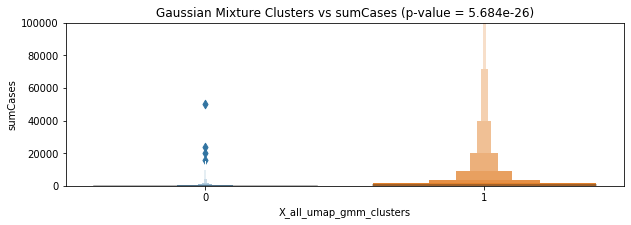

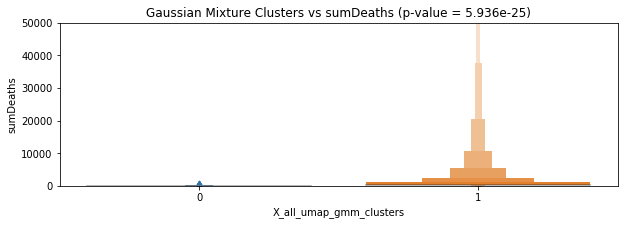

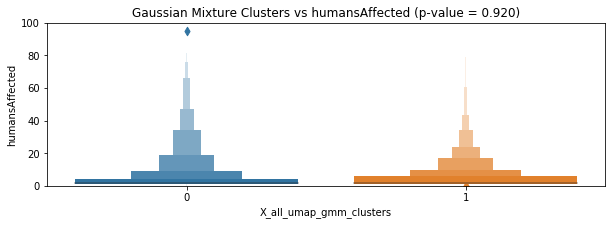

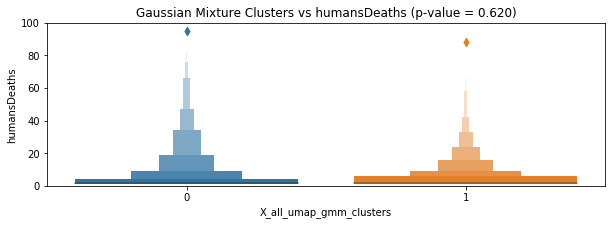

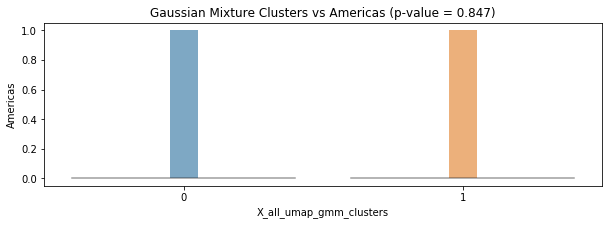

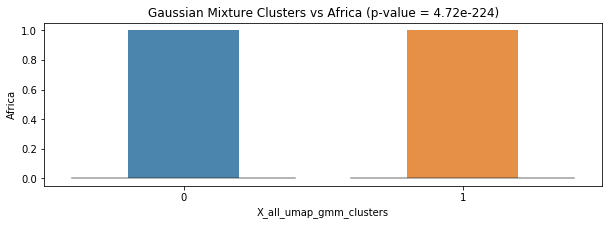

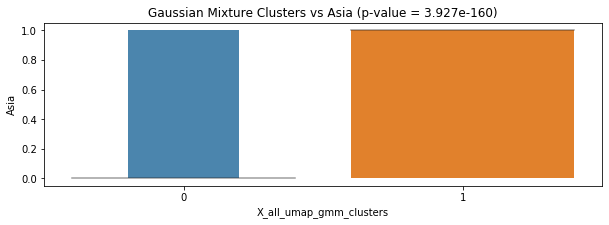

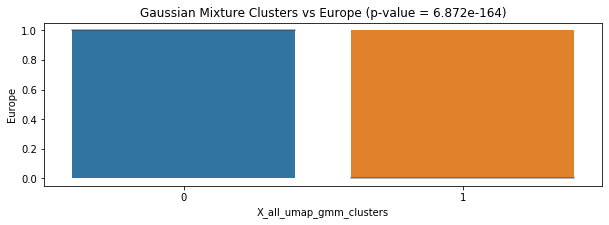

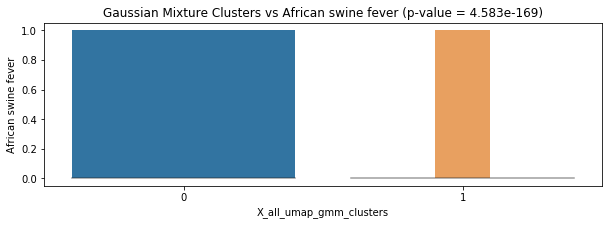

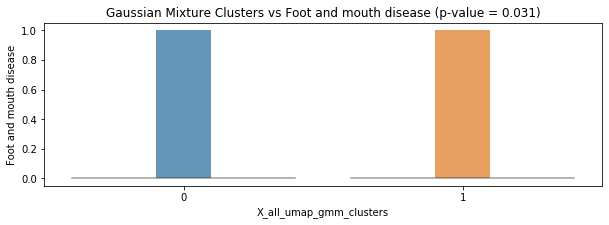

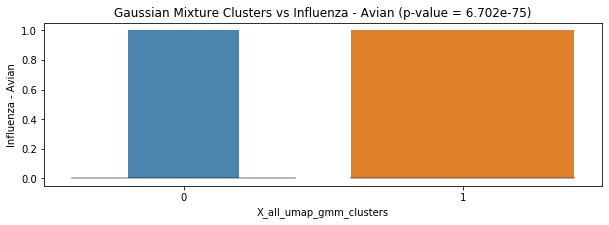

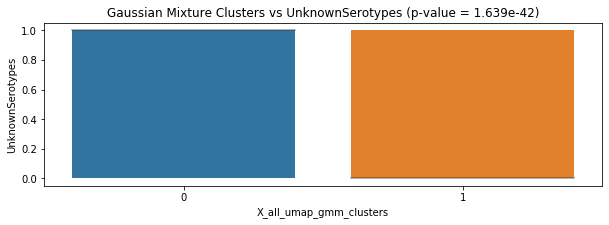

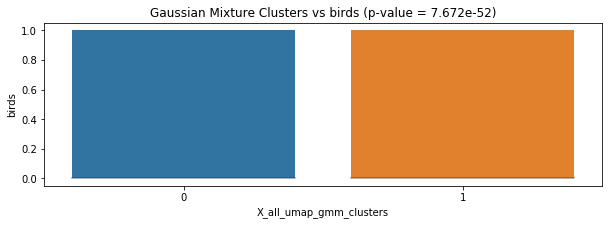

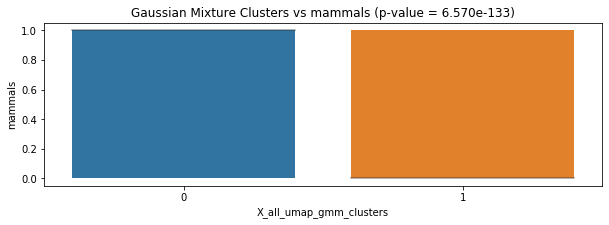

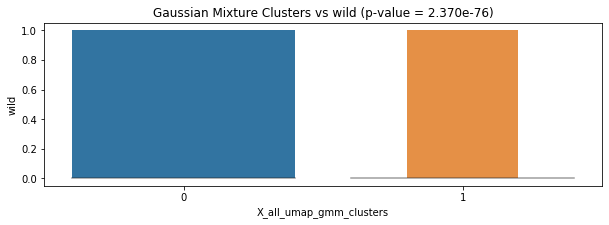

In [106]:
plot_gmm_clusters()

# Conclusions

The model I would choose for this data is the Agglomerative clustering, with ward linkage in particular. With the highest silhouette scores and reasonable Davies Bouldin indexes, it was more able to cluster the data in a meaningful way than the other models. 

The most important insight this analysis gave me is something that should be obvious but many may overthink: humans and animals react differently to different diseases. A primary reason for this could be exposure. Animals will create antibodies against diseases they're exposed to and their bodies will learn to fight them off. 

It's very interesting that disease outbreaks that affect humans are more closely linked with those in the wild category as opposed to domestic. Continuing the theme of exposure, this could be because the humans who spend time with domestic animals have been exposed to these diseases and built up antibodies to defend against them, whereas when we're exposed to something from a wild animal, it's likely that the disease will be new to us. Not having an opportunity to build up a tolerance is a reason these diseases may be more dangerous to us. Additionally, containing and handling diseases in domesticated communities must be exponentially easier than in the wild for obvious reasons, which may account for the correlation between outbreaks in the wild and the number of humans affected.

My next steps in this data would be to create a categorical target variable indicating whether a given disease outbreak is severe toward animals, humans, or both and see whether any dimensionality reduction or clustering techniques can properly map them out. I'd like to also test out some supervised learning models to see whether we can train a model to predict potentially pandemic diseases and which features are of upmost importance. 